# Initialize

In [38]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import os
import io
import logging
import time

import matplotlib as mpl
params = {'axes.spines.right': False,
          'axes.spines.top': False,
          'legend.fontsize': 12,
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'pdf.fonttype': 42,
          'ps.fonttype': 42}
mpl.rcParams.update(params)

import matplotlib.pyplot as plt
import sys, importlib
import pandas as pd

import nems0.modelspec as ms
import nems0.xforms as xforms
import nems0.xform_helper as xhelp
from nems0.utils import escaped_split, escaped_join
from nems0 import db
from nems0 import get_setting
from nems0.xform_helper import _xform_exists, load_model_xform, fit_model_xform
from nems0.registry import KeywordRegistry, xforms_lib, keyword_lib
from nems0.plugins import (default_keywords, default_loaders,
                          default_initializers, default_fitters)
from nems_lbhb import baphy_experiment
from nems_lbhb.exacloud.queue_exacloud_job import enqueue_exacloud_models

log = logging.getLogger(__name__)

In [2]:
from nems_lbhb.projects.olp.OLP_get_epochs import get_rec_epochs, get_stim_type, generate_cc_dataframe


In [429]:
batch=341
siteids, cellids = db.get_batch_sites(batch=batch)

In [430]:
print(cellids)

['ARM024a-05-2', 'ARM025a-05-1', 'ARM027a-09-5', 'ARM028b-04-1', 'ARM029a-04-1', 'ARM030a-05-2', 'ARM031a-06-2', 'ARM032a-12-1', 'ARM033a-02-2', 'CLT028c-002-1', 'CLT029c-003-1', 'CLT032c-003-1', 'CLT033c-001-2', 'CLT034c-022-1', 'CLT035c-003-1', 'CLT036c-001-2', 'CLT037c-004-1', 'CLT039c-002-1', 'CLT040c-003-1', 'CLT043b-004-1', 'CLT044d-001-2', 'CLT045d-010-1', 'CLT047c-003-1', 'CLT048c-002-1', 'CLT049c-020-1', 'CLT050c-007-1', 'CLT051c-037-1', 'CLT052d-004-1', 'PRN004a-001-2', 'PRN005a-064-1', 'PRN008a-078-1', 'PRN013c-046-1', 'PRN015b-006-1', 'PRN017b-087-2', 'PRN020b-027-1', 'PRN022a-042-1', 'PRN023a-072-1', 'PRN024a-066-1', 'PRN031a-006-4', 'PRN033a-001-1', 'PRN034a-001-3', 'PRN042a-005-1', 'PRN043a-063-1', 'PRN045b-051-1', 'PRN050a-018-1', 'PRN055a-139-1', 'PRN064a-046-1']


In [761]:
cid, cid0 = 33, 40
cid, cid0 = 31, 60
cid, cid0 = 11, 0
cellids[cid]

'CLT032c-003-1'

# Load models from one site

In [762]:
siteid, cellid = siteids[cid], cellids[cid]

modelname="gtgram.fs100.ch18-ld-norm.l1-sev.fOLP_wc.18x1x70.g-fir.15x1x70-relu.70.f-wc.70x1x80-fir.10x1x80-relu.80.f-wc.80x100-relu.100-wc.100xR-relu.R.o.s.g_prefit.b322.f.nf-lite.tf.init.lr1e3.t3.es20-lite.tf.lr1e4"
modelname2="gtgram.fs100.ch18-ld-norm.l1-sev.fOLP_wc.18x1x70.g-fir.15x1x70-relu.70.f-wc.70x1x80-fir.10x1x80-relu.80.f-wc.80x100-relu.100-wc.100xR-relu.R.o.s.g_lite.tf.init.lr1e3.t3.es20.rb5-lite.tf.lr1e4"
#modelname2="gtgram.fs100.ch18-ld-norm.l1-sev.fOLP_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322.f.nf-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"

modelname="gtgram.fs100.ch18-ld-norm.l1-sev.fOLP_wc.18x1x70.g-fir.15x1x70-relu.70.f-wc.70x1x80-fir.10x1x80-relu.80.f-wc.80x100-relu.100-wc.100xR-dexp.R_prefit.b322.f.nf-lite.tf.init.lr1e3.t3.es20-lite.tf.lr1e4.t4"
modelname2="gtgram.fs100.ch18-ld-norm.l1-sev.fOLP_wc.18x1x70.g-fir.15x1x70-relu.70.f-wc.70x1x80-fir.10x1x80-relu.80.f-wc.80x100-relu.100-wc.100xR-dexp.R_lite.tf.init.lr1e3.t3.es20.rb5-lite.tf.lr1e4.t4"

modelname="gtgram.fs100.ch18-ld-norm.l1-sev.fOLP_wc.18x1x70.g-fir.15x1x70-relu.70.f-wc.70x1x80-fir.10x1x80-relu.80.f-wc.80x100-relu.100-wc.100xR-dexp.R_prefit.b322.f.nf-lite.tf.init.lr1e3.t3.es20"
modelnames = [
    "gtgram.fs100.ch18-ld-norm.l1-sev.fOLP_wc.18x1x70.g-fir.15x1x70-relu.70.f-wc.70x1x80-fir.10x1x80-relu.80.f-wc.80x100-relu.100-wc.100xR-dexp.R_prefit.b322.f.nf-lite.tf.init.lr1e3.t3.es20-lite.tf.lr1e4",
    "gtgram.fs100.ch18-ld-norm.l1-sev.fOLP_wc.18x1x120.g-fir.25x1x120-wc.120xR-dexp.R_prefit.b322.f.nf-lite.tf.init.lr1e3.t3.es20-lite.tf.lr1e4",
]


In [763]:
#savefile=fit_model_xform(siteid, batch, modelname, saveInDB=True)

In [764]:
xf,ctx=load_model_xform(cellid, batch, modelnames[0])
xf2,ctx2=load_model_xform(cellid, batch, modelnames[1])

[nems0.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/341/CLT032c/NAT4v2_341_gtgram.fs100.ch18-ld-norm.l1-sev.fOLP_wc.18x1x70.g-fir.15x1x70-relu...1105573213304674621 ...
/auto/users/svd/python/nems/nems/models/base.py:103: UserWarning: Using `Model(dtype=...)` is currently experimental. For best results, leave dtype as the default. TF Backend will overwrite this setting to np.float32 for the time being.
  warnings.warn(
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] xf argument cellid overlaps with existing context key: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.load_recordings
[nems0.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/341/CLT032c_2d5aff84ad7f36f49b0510d7e22e9d71d2d8fd1c.tgz to /auto/data/nems_db/recordings/341/CLT032c_2d5aff84ad7f36f49b0510d7e22e9d71d2d8fd1c.tgz
[nems0.xforms INFO] Extracting cellid(s) ['CLT032

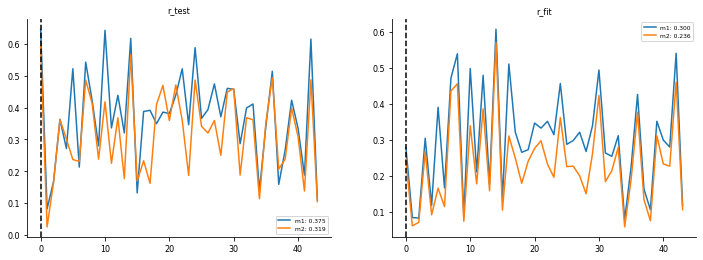

In [765]:
modelspec=ctx['modelspec']
modelspec2=ctx2['modelspec']

f,ax=plt.subplots(1,2,figsize=(12,4))
score='r_test'
ax[0].plot(modelspec.meta[score], label=f"m1: {modelspec.meta[score].mean():.3f}")
ax[0].plot(modelspec2.meta[score], label=f"m2: {modelspec2.meta[score].mean():.3f}")
ax[0].axvline(cid0, color='black', linestyle='--')
ax[0].set_title(score);
ax[0].legend();
score='r_fit'
ax[1].plot(modelspec.meta[score], label=f"m1: {modelspec.meta[score].mean():.3f}")
ax[1].plot(modelspec2.meta[score], label=f"m2: {modelspec2.meta[score].mean():.3f}")
ax[1].axvline(cid0, color='black', linestyle='--')
ax[1].set_title(score);
ax[1].legend();

# Find cells with interesting FG/BG suppression

In [766]:
from nems_lbhb.projects.olp.OLP_get_epochs import get_rec_epochs, generate_cc_dataframe, examine_cell_epoch
from nems_lbhb.baphy_experiment import BAPHYExperiment

In [767]:
use_model_rec=True
if use_model_rec:
    rec = ctx['val']
else:
    parmfile = ['/auto/data/daq/Armillaria/ARM024/ARM024a10_p_OLP.m']
    parmfile = ['/auto/data/daq/Armillaria/ARM025/ARM025a10_p_OLP.m']
    parmfile = ['/auto/data/daq/Clathrus/CLT008/CLT008a17_p_OLP.m']
    manager = BAPHYExperiment(parmfile)
    fs = 50
    options = {'rasterfs': fs, 'stim': True, 'stimfmt': 'lenv', 'resp': True, 'recache': False}
    rec = manager.get_recording(**options)

resp = ctx['val']['resp'].rasterize()
pred1 = ctx['val']['pred'].rasterize()
pred2 = ctx2['val']['pred'].rasterize()
stim = ctx['val']['stim'].rasterize()
fs = resp.fs

In [768]:
epoch_df = get_rec_epochs(fs=50, rec=rec)
epoch_df.shape

(84, 7)

In [769]:
epoch_df

,BG + FG,BG,FG,Synth Type,Binaural Type,Dynamic Type,SNR
0,STIM_05RockTumble-0-1-1-A_02Gobble-0-1-1-A,STIM_05RockTumble-0-1-1-A_null,STIM_null_02Gobble-0-1-1-A,Non-RMS Unsynthetic,"BG Contra, FG Contra",fullBG/fullFG,0
1,STIM_05RockTumble-0-1-1-A_22Typing-0-1-1-A,STIM_05RockTumble-0-1-1-A_null,STIM_null_22Typing-0-1-1-A,Non-RMS Unsynthetic,"BG Contra, FG Contra",fullBG/fullFG,0
2,STIM_05RockTumble-0-1-1-A_35Dice-0-1-1-A,STIM_05RockTumble-0-1-1-A_null,STIM_null_35Dice-0-1-1-A,Non-RMS Unsynthetic,"BG Contra, FG Contra",fullBG/fullFG,0
3,STIM_05RockTumble-0-1-1-A_38ManA-0-1-1-A,STIM_05RockTumble-0-1-1-A_null,STIM_null_38ManA-0-1-1-A,Non-RMS Unsynthetic,"BG Contra, FG Contra",fullBG/fullFG,0
4,STIM_05RockTumble-0-1-1-C_02Gobble-0-1-1-C,STIM_05RockTumble-0-1-1-C_null,STIM_null_02Gobble-0-1-1-C,Cochlear,"BG Contra, FG Contra",fullBG/fullFG,0
...,...,...,...,...,...,...,...
79,STIM_27Chainsaw-0-1-1-T_38ManA-0-1-1-T,STIM_27Chainsaw-0-1-1-T_null,STIM_null_38ManA-0-1-1-T,Temporal,"BG Contra, FG Contra",fullBG/fullFG,0
80,STIM_27Chainsaw-0-1-1-U_02Gobble-0-1-1-U,STIM_27Chainsaw-0-1-1-U_null,STIM_null_02Gobble-0-1-1-U,Spectrotemporal,"BG Contra, FG Contra",fullBG/fullFG,0
81,STIM_27Chainsaw-0-1-1-U_22Typing-0-1-1-U,STIM_27Chainsaw-0-1-1-U_null,STIM_null_22Typing-0-1-1-U,Spectrotemporal,"BG Contra, FG Contra",fullBG/fullFG,0
82,STIM_27Chainsaw-0-1-1-U_35Dice-0-1-1-U,STIM_27Chainsaw-0-1-1-U_null,STIM_null_35Dice-0-1-1-U,Spectrotemporal,"BG Contra, FG Contra",fullBG/fullFG,0


In [770]:
epoch_df = epoch_df.loc[(epoch_df['Dynamic Type']=='fullBG/fullFG') & 
                        ((epoch_df['Synth Type']=='Unsynthetic') | (epoch_df['Synth Type']=='Non-RMS Unsynthetic'))]
epoch_df.shape

(24, 7)

In [784]:
L = []
for cellid in resp.chans[cid0:]:
    e = epoch_df.copy()
    e['cellid']=cellid
    e['cellstd']=resp.extract_channels([cellid]).as_continuous().std()
    
    L.append(e)
cell_epoch_df = pd.concat(L, ignore_index=True)

prefs = ['r','p1','p2']
sigs=[resp, pred1, pred2]
for pre in prefs:
    cell_epoch_df[pre+'fg']=np.nan
    cell_epoch_df[pre+'bg']=np.nan
    cell_epoch_df[pre+'wfg']=np.nan
    cell_epoch_df[pre+'wbg']=np.nan
cell_epoch_df['rw0']=np.nan
cell_epoch_df.shape

(1056, 22)

In [785]:
def add_noise(psth,reps=20,prat=1):
    p=psth.copy()
    p[p<0]=0
    r=np.random.poisson(prat*p[:,np.newaxis],(len(p),reps)) + \
                        np.random.normal((1-prat)*p[:,np.newaxis],(1-prat)*p[:,np.newaxis]/2,(len(p),reps))
    r[r<0]=0
    
    return r.mean(axis=1)


In [786]:
sp=int(fs*0.5)

for id, r in cell_epoch_df.iterrows():
    cellid = r['cellid']
    epoch_fg=r['FG']
    epoch_bg=r['BG']
    epoch_fgbg=r['BG + FG']
    
    m = int(ctx['rec']['resp'].extract_channels([cellid]).extract_epoch(epoch_fgbg).shape[0]/2)
    rfgbg1 = ctx['rec']['resp'].extract_channels([cellid]).extract_epoch(epoch_fgbg)[:m,:,:].mean(axis=0)[0,:]
    rfgbg2 = ctx['rec']['resp'].extract_channels([cellid]).extract_epoch(epoch_fgbg)[m:,:,:].mean(axis=0)[0,:]
    spont = (rfgbg1[:sp].mean()+rfgbg2[:sp].mean())/2
    
    weights0,_,_,_ = np.linalg.lstsq(np.stack([rfgbg1-spont, np.ones_like(rfgbg1)], axis=1), rfgbg2-spont, rcond=None)   

    for pre,sig in zip(prefs, sigs):
        rfg = sig.extract_channels([cellid]).extract_epoch(epoch_fg).mean(axis=0)[0,:] / r['cellstd']
        rbg = sig.extract_channels([cellid]).extract_epoch(epoch_bg).mean(axis=0)[0,:] / r['cellstd']
        rfgbg = sig.extract_channels([cellid]).extract_epoch(epoch_fgbg).mean(axis=0)[0,:] / r['cellstd']
        
        if ii>0:
            rfg=add_noise(rfg)
            rbg=add_noise(rbg)
            rfgbg=add_noise(rfgbg)

        
        spont = (rfg[:sp].mean()+rbg[:sp].mean()+rfgbg[:sp].mean())/3

        rfg0 = rfg-spont
        rbg0 = rbg-spont
        rfgbg0 = rfgbg-spont
        weights2,residual_sum,rank,singular_values = np.linalg.lstsq(np.stack([rfg0, rbg0], axis=1), rfgbg0, rcond=None)   
        #weights,residual_sum,rank,singular_values = np.linalg.lstsq(np.stack([rfg, rbg, np.ones_like(rfg)], axis=1), rfgbg, rcond=None)   

        cell_epoch_df.at[id,pre+'wfg'] = weights2[0]
        cell_epoch_df.at[id,pre+'wbg'] = weights2[1]
        cell_epoch_df.at[id,pre+'fg'] = rfg0[sp:-sp].mean()
        cell_epoch_df.at[id,pre+'bg'] = rbg0[sp:-sp].mean()
    cell_epoch_df.at[id,'rw0'] = weights0[0]


array([0.16957211, 0.00063391])

((1056, 22), 0.553030303030303)

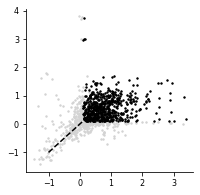

In [787]:
rFB = (cell_epoch_df['rfg']>0.1) & (cell_epoch_df['rbg']>0.1) & \
    (cell_epoch_df['rwfg']>0) & (cell_epoch_df['rwbg']>0) & \
    (cell_epoch_df['rwfg']<2) & (cell_epoch_df['rwbg']<2)

plt.figure(figsize=(3,3))
plt.plot([-1, 1],[-1, 1], 'k--')
plt.scatter(cell_epoch_df.loc[~rFB,'rfg'],cell_epoch_df.loc[~rFB,'rbg'], s=2, color='lightgray')
plt.scatter(cell_epoch_df.loc[rFB,'rfg'],cell_epoch_df.loc[rFB,'rbg'], s=2, color='black')
cell_epoch_df.shape, rFB.mean()

rwfg     0.261753
rwbg     0.409893
p1wfg    0.418346
p1wbg    0.717322
p2wfg    0.421987
p2wbg    0.710889
dtype: float64


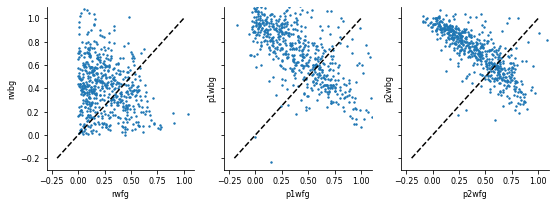

In [788]:
f,axs = plt.subplots(1,3,figsize=(9,3),sharex='row',sharey='row')
for pre,ax in zip(prefs, axs):
    ax.plot([-.2, 1],[-.2, 1], 'k--')
    ax.scatter(cell_epoch_df.loc[rFB,pre+'wfg'],cell_epoch_df.loc[rFB,pre+'wbg'], s=2)
    ax.set_xlabel(pre+'wfg')
    ax.set_ylabel(pre+'wbg')
    ax.set_xlim([-0.3, 1.1])
    ax.set_ylim([-0.3, 1.1])
    
print(cell_epoch_df.loc[rFB,['rwfg','rwbg','p1wfg','p1wbg','p2wfg','p2wbg']].mean())

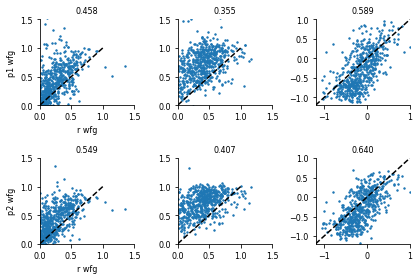

In [789]:
f,axs = plt.subplots(2,3,figsize=(6,4))
for pre,ax in zip(prefs[1:], axs):
    ax[0].plot([0, 1],[0, 1], 'k--')
    ax[1].plot([0, 1],[0, 1], 'k--')
    ax[2].plot([-1.2, 1],[-1.2, 1], 'k--')
    
    fr = cell_epoch_df.loc[rFB, 'rwfg']
    fp = cell_epoch_df.loc[rFB, pre+'wfg']
    
    br = cell_epoch_df.loc[rFB, 'rwbg']
    bp = cell_epoch_df.loc[rFB, pre+'wbg']
    
    dr = cell_epoch_df.loc[rFB, 'rwfg'] - cell_epoch_df.loc[rFB, 'rwbg']
    dp = cell_epoch_df.loc[rFB, pre+'wfg'] - cell_epoch_df.loc[rFB, pre+'wbg']
    ax[0].scatter(fr,fp, s=2)
    ax[1].scatter(br,bp, s=2)
    ax[2].scatter(dr,dp, s=2)
    ax[0].set_title(f"{np.corrcoef(fr,fp)[0,1]:.3f}")
    ax[0].set_ylabel(pre+' wfg')
    ax[0].set_xlabel('r wfg')
    ax[0].set_xlim([0,1.5])
    ax[0].set_ylim([0,1.5])
    ax[1].set_xlim([0,1.5])
    ax[1].set_ylim([0,1.5])
    ax[1].set_title(f"{np.corrcoef(br,bp)[0,1]:.3f}")
    ax[2].set_xlim([-1.2,1])
    ax[2].set_ylim([-1.2,1])
    ax[2].set_title(f"{np.corrcoef(dr,dp)[0,1]:.3f}")
plt.tight_layout()


In [791]:
# list some examples
cols = ['cellid','BG + FG', 'rfg','rbg','rwfg','rwbg','p1wfg','p1wbg','p2wfg','p2wbg','rw0']
cell_epoch_df.loc[rFB & (cell_epoch_df['rwfg']<0.3) & (cell_epoch_df['rwbg']>0.6) & (cell_epoch_df['rfg']>cell_epoch_df['rbg']), cols]

,cellid,BG + FG,rfg,rbg,rwfg,rwbg,p1wfg,p1wbg,p2wfg,p2wbg,rw0
126,CLT032c-018-2,STIM_05RockTumble-0-1-1-N_35Dice-0-1-1-N,2.945333,1.435833,0.234464,0.620850,0.534027,0.510701,0.639265,0.766308,0.585196
170,CLT032c-021-2,STIM_05RockTumble-0-1-1-A_35Dice-0-1-1-A,0.389333,0.306333,0.132327,0.631265,0.105845,0.782150,0.090831,0.908772,0.288288
174,CLT032c-021-2,STIM_05RockTumble-0-1-1-N_35Dice-0-1-1-N,0.816833,0.325833,0.245895,0.839865,0.537854,0.381189,0.431289,0.689863,0.700598
177,CLT032c-021-2,STIM_08Waterfall-0-1-1-A_22Typing-0-1-1-A,1.534333,0.146333,0.005951,0.929280,0.020952,0.993371,0.078993,0.977810,0.732836
178,CLT032c-021-2,STIM_08Waterfall-0-1-1-A_35Dice-0-1-1-A,0.400500,0.136500,0.204525,0.855990,0.006101,1.059468,0.007947,0.951217,0.578118
...,...,...,...,...,...,...,...,...,...,...,...
1018,CLT032c-061-1,STIM_08Waterfall-0-1-1-A_35Dice-0-1-1-A,0.940667,0.797667,0.173115,0.793432,0.227409,0.995099,-0.095790,0.980105,0.682899
1019,CLT032c-061-1,STIM_08Waterfall-0-1-1-A_38ManA-0-1-1-A,1.217000,0.773500,0.068342,0.756027,0.088181,0.882931,0.118875,0.898329,0.578379
1025,CLT032c-061-1,STIM_27Chainsaw-0-1-1-A_22Typing-0-1-1-A,1.534167,0.897167,0.081162,0.628019,0.236346,0.782620,0.253576,0.814055,0.610401
1027,CLT032c-061-1,STIM_27Chainsaw-0-1-1-A_38ManA-0-1-1-A,1.297500,0.983000,0.113479,0.750132,0.247629,0.924497,0.062186,0.950149,0.863613


In [739]:
sbg.shape

(18, 200)

[0.28 0.68]


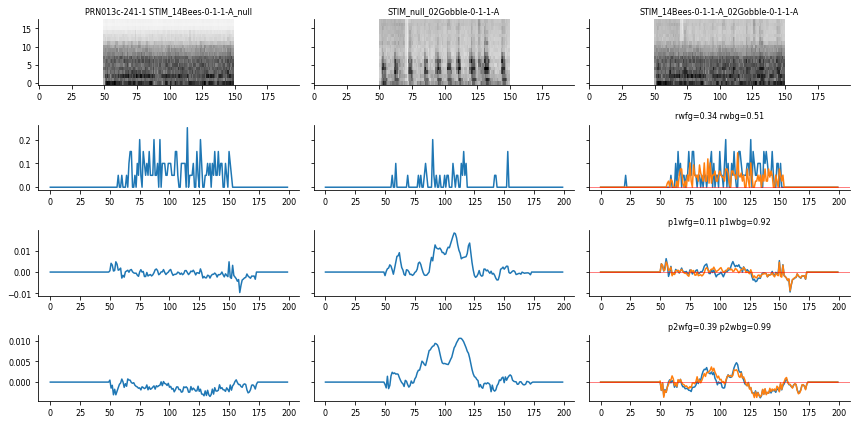

In [697]:
ii = [161] # PRN017 fg enhancement (rarity)
ii = [93] # PRN017 total suppression of fg
ii = [579] # PRN015 fg enhancement (rarity)
ii = [336] # PRN015 total suppression of fg
#cellid="CLT008a-019-3"
#cellid="CLT008a-046-2"
#epoch_fg='Geese'
#epoch_bg='Wind'

#ii = (cell_epoch_df.cellid == cellid) &\
#        cell_epoch_df['BG'].str.contains(epoch_bg) & \
#        cell_epoch_df['FG'].str.contains(epoch_fg)
cellid=cell_epoch_df.loc[ii,'cellid'].values[0]
efg=cell_epoch_df.loc[ii,'FG'].values[0]
ebg=cell_epoch_df.loc[ii,'BG'].values[0]
efgbg=cell_epoch_df.loc[ii,'BG + FG'].values[0]

#rfg = pred1.extract_channels([cellid]).extract_epoch(efg).mean(axis=0)[0,:]
#rbg = pred1.extract_channels([cellid]).extract_epoch(ebg).mean(axis=0)[0,:]
#rfgbg = pred1.extract_channels([cellid]).extract_epoch(efgbg).mean(axis=0)[0,:]
sfg = stim.extract_epoch(efg).mean(axis=0)
sbg = stim.extract_epoch(ebg).mean(axis=0)
sfgbg = stim.extract_epoch(efgbg).mean(axis=0)

#weights,residual_sum,rank,singular_values = np.linalg.lstsq(np.stack([rfg, rbg, np.ones_like(rfg)], axis=1), rfgbg,rcond=None)   
#print(np.round(weights,2))

sp=int(fs*0.5)
spont = (rfg[:sp].mean()+rbg[:sp].mean()+rfgbg[:sp].mean()) / 3

rfg = resp.extract_channels([cellid]).extract_epoch(efg).mean(axis=0)[0,:]
rbg = resp.extract_channels([cellid]).extract_epoch(ebg).mean(axis=0)[0,:]
rfgbg = resp.extract_channels([cellid]).extract_epoch(efgbg).mean(axis=0)[0,:]

rfg0 = rfg-spont
rbg0 = rbg-spont
rfgbg0 = rfgbg-spont
weights2, residual_sum, rank, singular_values = np.linalg.lstsq(np.stack([rfg0, rbg0], axis=1), rfgbg0, rcond=None)   
print(np.round(weights2, 2))

imopts = {'origin': 'lower', 'interpolation': 'none', 'cmap': 'gray_r', 'aspect': 'auto'}
f,ax = plt.subplots(4,3, sharey='row', figsize=(12,6))
ax[0,0].imshow(sbg, **imopts)
ax[0,1].imshow(sfg, **imopts)
ax[0,2].imshow(sfgbg, **imopts)
ax[0,0].set_title(cellid + " " + ebg)
ax[0,1].set_title(efg)
ax[0,2].set_title(efgbg)

for ii, pre,sig in zip(range(len(sigs)), prefs, sigs):
    rfg = sig.extract_channels([cellid]).extract_epoch(epoch_fg).mean(axis=0)[0,:]
    rbg = sig.extract_channels([cellid]).extract_epoch(epoch_bg).mean(axis=0)[0,:]
    rfgbg = sig.extract_channels([cellid]).extract_epoch(epoch_fgbg).mean(axis=0)[0,:]
    
    if ii>20:
        rfg=add_noise(rfg)
        rbg=add_noise(rbg)
        rfgbg=add_noise(rfgbg)

    spont = (rfg[:sp].mean()+rbg[:sp].mean()+rfgbg[:sp].mean())/3
    rfg0 = rfg-spont
    rbg0 = rbg-spont
    rfgbg0 = rfgbg-spont
    weights2,residual_sum,rank,singular_values = np.linalg.lstsq(np.stack([rfg0, rbg0], axis=1), rfgbg0, rcond=None)   
    #weights,residual_sum,rank,singular_values = np.linalg.lstsq(np.stack([rfg, rbg, np.ones_like(rfg)], axis=1), rfgbg, rcond=None)   

    ax[ii+1,0].plot(rbg0)
    ax[ii+1,1].plot(rfg0)
    ax[ii+1,2].plot(rfgbg0)
    ax[ii+1,2].plot((rfg0)*weights2[0]+(rbg0)*weights2[1])
    ax[ii+1,2].axhline(0, color='r', lw=0.5)
    ax[ii+1,2].set_title(f'{pre}wfg={weights2[0]:.2f} {pre}wbg={weights2[1]:.2f}')
plt.tight_layout()


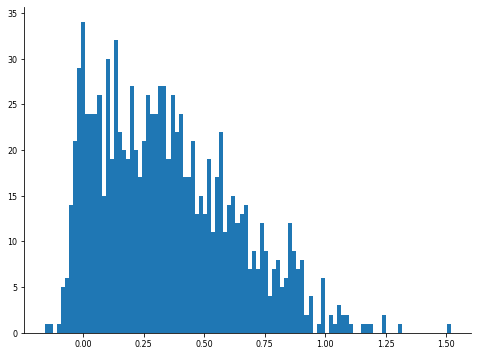

In [800]:
plt.figure()
plt.hist(cell_epoch_df['rw0'], 100);

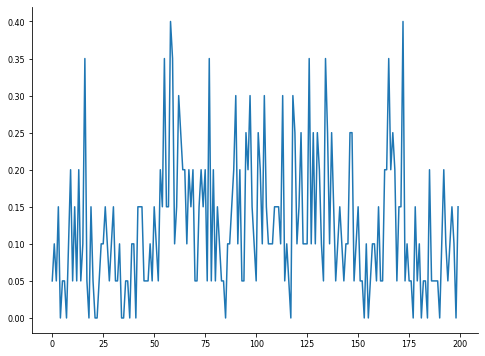

In [591]:
p=rfg
p[p<0]=0
r=np.random.poisson(p[:,np.newaxis],(200,20))
plt.figure()
plt.plot(r.mean(axis=1))

In [250]:
#epoch_df = get_rec_epochs(fs=100, rec=ctx['val'])
epoch_df_all = generate_cc_dataframe(rec=ctx['val'])

In [239]:
epoch_df_all.loc[0]

index                                                      0
BG + FG            STIM_03Insect_Buzz-0-1_01Fight_Squeak-0-1
BG                               STIM_03Insect_Buzz-0-1_null
FG                              STIM_null_01Fight_Squeak-0-1
Synth Type                               Non-RMS Unsynthetic
Binaural Type                           BG Contra, FG Contra
Dynamic Type                                   fullBG/fullFG
SNR                                                        0
cellid                                          ARM024a-05-2
cbb                                                  -0.0549
cff                                                 0.008715
crfb                                                -0.02902
cc(BG,sum)                                          0.442485
cc(FG,sum)                                          0.883557
cc(BG,FGBG)                                         0.031267
cc(FG,FGBG)                                         0.127809
Eb                      

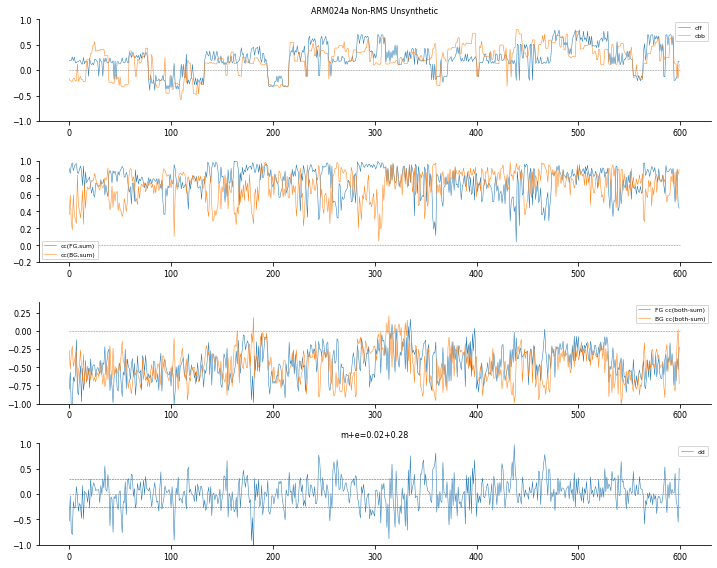

In [294]:
rec=ctx['rec']
resp = rec['resp'].rasterize()

stim = rec['stim'].rasterize()

types = {'N': 'Natural RMS', 'U': 'Spectrotemporal', 'S': 'Spectral', 'T': 'Temporal', 'C': 'Cochlear'}
#types = {'N': 'Natural RMS', 'U': 'Spectrotemporal', 'S': 'Spectral', 'T': 'Temporal', 'C': 'Cochlear'}
#types ={'A': 'Natural max', 'N': 'Natural RMS', 'C': 'Cochlear', 'T': 'Temporal',
#         'S': 'Spectral', 'U': 'Spectrotemporal', 'M': 'SpectrotemporalMod',
#         }
types = {'A': 'Non-RMS Unsynthetic'}
basename=rec.name

f, axs = plt.subplots(4, len(types), figsize=(10, 8))
if len(types)==1:
    axs=np.array([axs]).T
for t,ax in zip(types.keys(),axs.T):
    # both E
    # nat_epoch_df = epoch_df_all.loc[(epoch_df_all['cff'] > 0.1) & (epoch_df_all['cbb'] > 0.1) & epoch_df_all['BG + FG'].str.endswith(t)].reset_index()

    # both I
    #nat_epoch_df = epoch_df_all.loc[(epoch_df_all['cff']<-0.1) & (epoch_df_all['cbb']<-0.1) & epoch_df_all['BG + FG'].str.endswith(t)].reset_index()

    # both respond
    #nat_epoch_df = epoch_df_all.loc[(np.abs(epoch_df_all['cff'])>0.1) & (np.abs(epoch_df_all['cbb'])>0.1) & epoch_df_all['BG + FG'].str.endswith(t)].reset_index()
    nat_epoch_df = epoch_df_all.loc[(np.abs(epoch_df_all['cff'])>0.1) & (np.abs(epoch_df_all['cbb'])>0.1)].reset_index()

    ax[0].set_title(f'{basename} {types[t]}')

    nat_epoch_df[['cff','cbb']].plot(lw=0.5,ax=ax[0])
    ax[0].plot([0,len(nat_epoch_df)],[0,0],'--', color='gray', lw=0.5)
    ax[0].set_ylim([-1.0, 1.0])

    nat_epoch_df[['cc(FG,sum)','cc(BG,sum)']].plot(lw=0.5,ax=ax[1])
    ax[1].plot([0,len(nat_epoch_df)],[0,0],'--', color='gray', lw=0.5)
    ax[1].set_ylim([-0.2, 1.0])

    nat_epoch_df[['FG cc(both-sum)','BG cc(both-sum)']].plot(lw=0.5,ax=ax[2])
    #nat_epoch_df[['cc(FG,FGBG)','cc(BG,FGBG)']].plot(lw=0.5,ax=ax[2])
    ax[2].plot([0,len(nat_epoch_df)],[0,0],'--', color='gray', lw=0.5)
    ax[2].set_ylim([-1.0, 0.4])

    k = 'dd'
    #k = 'ddraw'
    nat_epoch_df[[k]].plot(lw=0.5,ax=ax[3])
    ax[3].plot([0,len(nat_epoch_df)],[0,0],'--', color='gray', lw=0.5)
    ax[3].set_ylim([-1.0, 1.0])
    m = nat_epoch_df[k].mean()
    e = nat_epoch_df[k].std()
    ax[3].plot([0,len(nat_epoch_df)],[m-e,m-e],'r--', lw=0.5)
    ax[3].plot([0,len(nat_epoch_df)],[m+e,m+e],'r--', lw=0.5)
    ax[3].set_title(f"m+e={m:.2f}+{e:.2f}")
plt.tight_layout()


In [295]:
from nems_lbhb.projects.olp.OLP_get_epochs import get_rec_epochs, get_stim_type, generate_cc_dataframe


In [296]:
nat_epoch_df.loc[175:185,['cellid','BG + FG', 'cff', 'cbb', 'dd']]


,cellid,BG + FG,cff,cbb,dd
175,ARM024a-29-1,STIM_10Wind-0.5-1_01Fight_Squeak-0.5-1,0.323659,0.159109,0.371495
176,ARM024a-29-1,STIM_10Wind-0.5-1_08Kit_Whine-0-1,0.150377,0.159109,0.053880
177,ARM024a-29-1,STIM_10Wind-0.5-1_08Kit_Whine-0.5-1,0.136852,0.159109,-0.171165
178,ARM024a-29-2,STIM_03Insect_Buzz-0-1_01Fight_Squeak-0-1,0.292954,0.131988,-0.111554
179,ARM024a-29-2,STIM_03Insect_Buzz-0-1_01Fight_Squeak-0.5-1,0.419650,0.131988,-0.918543
180,ARM024a-29-2,STIM_03Insect_Buzz-0-1_08Kit_Whine-0-1,0.435484,0.131988,-0.464711
181,ARM024a-29-2,STIM_03Insect_Buzz-0-1_08Kit_Whine-0.5-1,0.451380,0.131988,-1.176266
182,ARM024a-29-2,STIM_03Insect_Buzz-0.5-1_01Fight_Squeak-0-1,0.292954,0.241083,0.306350
183,ARM024a-29-2,STIM_03Insect_Buzz-0.5-1_01Fight_Squeak-0.5-1,0.419650,0.241083,-0.126526
184,ARM024a-29-2,STIM_03Insect_Buzz-0.5-1_08Kit_Whine-0-1,0.435484,0.241083,0.198977


In [286]:
efg = nat_epoch_df.iloc[0]['FG']
efg

'STIM_null_01Fight_Squeak-0-1'

(20, 1, 200)
[-0.1   0.85 -0.  ]


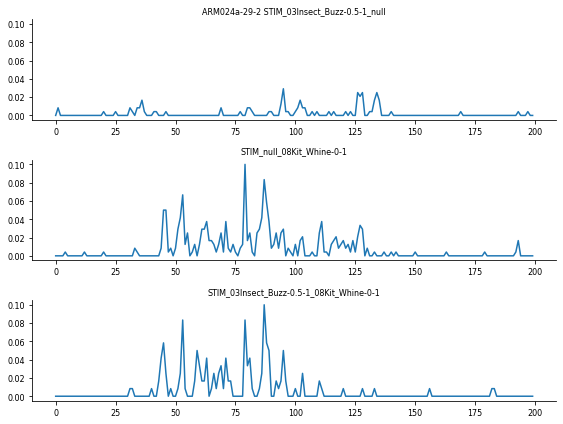

In [302]:
id =184
cellid=nat_epoch_df.loc[id,'cellid']
epoch_fg=nat_epoch_df.loc[id,'FG']
epoch_bg=nat_epoch_df.loc[id,'BG']

efg = nat_epoch_df.loc[id,'FG']
ebg = nat_epoch_df.loc[id,'BG']
efgbg = nat_epoch_df.loc[id,'BG + FG']
epochs
rbg = resp.extract_channels([cellid]).extract_epoch(ebg).mean(axis=0)[0,:]
rfg = resp.extract_channels([cellid]).extract_epoch(efg).mean(axis=0)[0,:]
rfgbg = resp.extract_channels([cellid]).extract_epoch(efgbg).mean(axis=0)[0,:]
print(resp.extract_channels([cellid]).extract_epoch(efgbg).shape)

f,ax = plt.subplots(3,1, sharey='col')
ax[0].plot(rbg)
ax[0].set_title(cellid + " " + ebg)
ax[1].plot(rfg)
ax[1].set_title(efg)
ax[2].plot(rfgbg)
ax[2].set_title(efgbg)
plt.tight_layout()
weights,residual_sum,rank,singular_values = np.linalg.lstsq(np.stack([rbg, rfg, np.ones_like(rfg)], axis=1), rfgbg,rcond=None)   
print(np.round(weights,2))


In [283]:
weights

array([0.27633727, 0.06954974, 0.0015175 ])

# Play around with dSTRF projection and visualization

In [98]:
modelspec = ctx['modelspec']
sig='val'
stim = ctx[sig]['stim'].as_continuous().T
estim = ctx['est']['stim'].as_continuous().T
resp = ctx[sig]['resp'].as_continuous().T
pred = ctx[sig]['pred'].as_continuous().T
print(stim.shape)

(9600, 18)


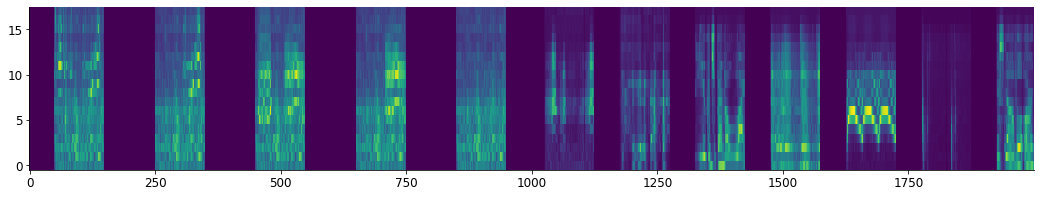

In [99]:
plt.figure(figsize=(18,3));
imopts = {'interpolation': 'none', 'origin': 'lower', 'aspect': 'auto'}
plt.imshow(np.concatenate((stim[:1000,:],estim[:1000,:]), axis=0).T, **imopts)

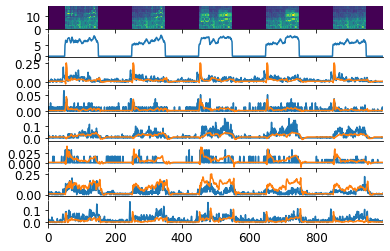

In [201]:
D=25
#out_channels = [11, 14, 21, 23]
out_channels = [30, 32, 35, 36, 37, 38]
#t_indexes = np.arange(1070,1270,20)
t_indexes = np.arange(1050,1150,20)

f,ax=plt.subplots(len(out_channels)+2,1, sharex='col')
imopts = {'interpolation': 'none', 'origin': 'lower', 'aspect': 'auto'}
ax[0].imshow(stim[:1000,:].T, **imopts)
ax[1].plot(stim[:1000,:].sum(axis=1))
for i,out_channel in enumerate(out_channels):
    ax[i+2].plot(resp[:1000,out_channel])
    ax[i+2].plot(pred[:1000,out_channel])

In [202]:
modelspec.dstrf_backend=None

In [203]:
dstrf = modelspec.dstrf(stim, D=D, out_channels=out_channels, t_indexes=t_indexes)

[nems.models.base INFO] Removing last layer for dstrf: dexp
[nems.backends.tf.backend INFO] TF model built. (verbose=1)
[nems.backends.tf.backend INFO] Model: "UnnamedModel"
[nems.backends.tf.backend INFO] _________________________________________________________________
[nems.backends.tf.backend INFO]  Layer (type)                Output Shape              Param #   
[nems.backends.tf.backend INFO] =================================================================
[nems.backends.tf.backend INFO]  input (InputLayer)          [(None, 25, 18)]          0         
[nems.backends.tf.backend INFO]  wc (WeightChannelsGaussianT  (None, 25, 1, 70)        140       
[nems.backends.tf.backend INFO]  F)                                                              
[nems.backends.tf.backend INFO]  fir (FiniteImpulseResponseT  (None, 25, 70)           1050      
[nems.backends.tf.backend INFO]  F)                                                              
[nems.backends.tf.backend INFO]  relu (Rec

ARM024a-48-2 0.4074644968137111
ARM024a-50-1 0.3168353019166603
ARM024a-52-1 0.47403230124056545
ARM024a-53-1 0.37881926631821555
ARM024a-54-1 0.5230326013951582
ARM024a-54-2 0.45866929152781255


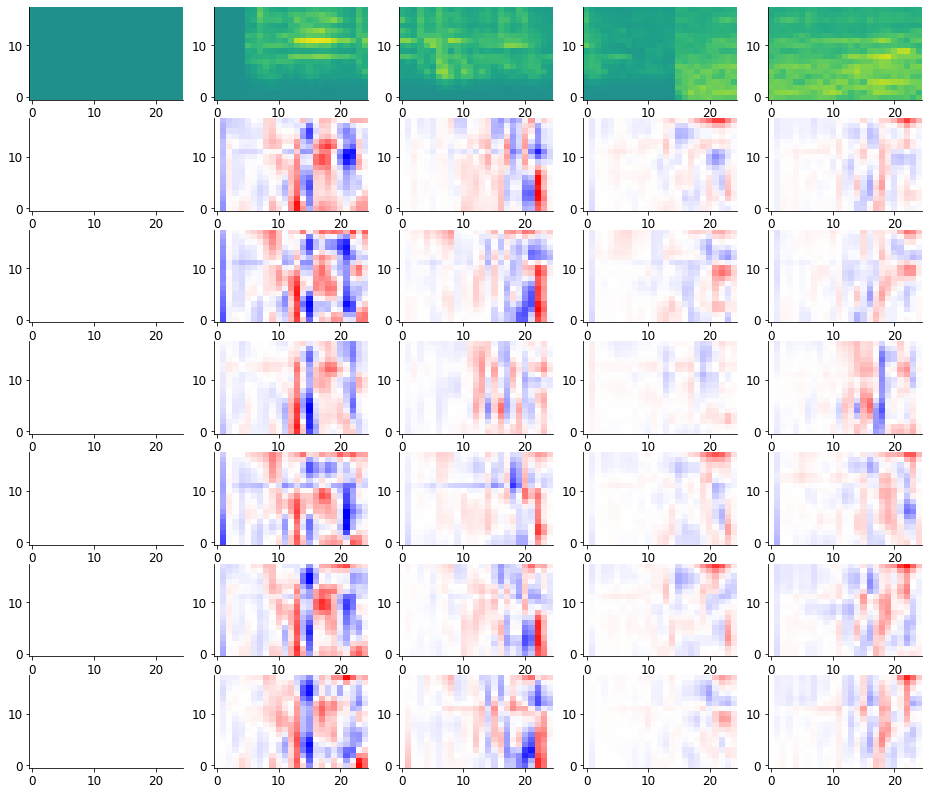

In [204]:
imopts = {'interpolation': 'none', 'origin': 'lower', 'aspect': 'auto'}
f,ax = plt.subplots(1+len(out_channels), len(t_indexes), figsize=(16,2*(1+len(out_channels))))
smax = np.max(np.abs(stim[:t_indexes[-1],:]))
for i,t in enumerate(t_indexes):
    ax[0,i].imshow(stim[(t-D):t, :].T, vmin=-smax, vmax=smax, **imopts)
    for j,out_channel in enumerate(out_channels):
        vmax = np.max(np.abs(dstrf[j, :, :, :]))
        ax[1+j,i].imshow(dstrf[j, i, :, :], vmin=-vmax, vmax=vmax, cmap='bwr', **imopts)

In [205]:
#out_channels=[11, 14, 21, 23]  # ARM031 examples
#out_channels = [0, 1, 2, 3, 4, 5, 6]

t_indexes=np.arange(0,estim.shape[0],5)
stimamp = estim.sum(axis=1)
t_indexes=np.where(stimamp>stimamp.min())[0]
t_indexes=t_indexes[t_indexes>D]
print(len(t_indexes))
dstrf = modelspec.dstrf(estim, D=D, out_channels=out_channels, t_indexes=t_indexes)
stimstd=stim.std(axis=0, keepdims=True)[:,np.newaxis,:,np.newaxis]
stimstd[stimstd==0]=1
dstrf = dstrf * stimstd

59240
ARM024a-48-2 0.4074644968137111
ARM024a-50-1 0.3168353019166603
ARM024a-52-1 0.47403230124056545
ARM024a-53-1 0.37881926631821555
ARM024a-54-1 0.5230326013951582
ARM024a-54-2 0.45866929152781255


In [206]:
from nems.tools.dstrf import compute_dpcs, dpc_project
pc_count=3
pcs,pc_mag=compute_dpcs(dstrf[:,:,:18,:], pc_count=pc_count)
print(pc_mag.T)

[[0.65893587 0.24514746 0.09591666]
 [0.59102888 0.24569677 0.16327435]
 [0.39861029 0.34924056 0.25214916]
 [0.63330801 0.22021756 0.14647443]
 [0.48839695 0.27393292 0.23767013]
 [0.52901477 0.29990362 0.1710816 ]]


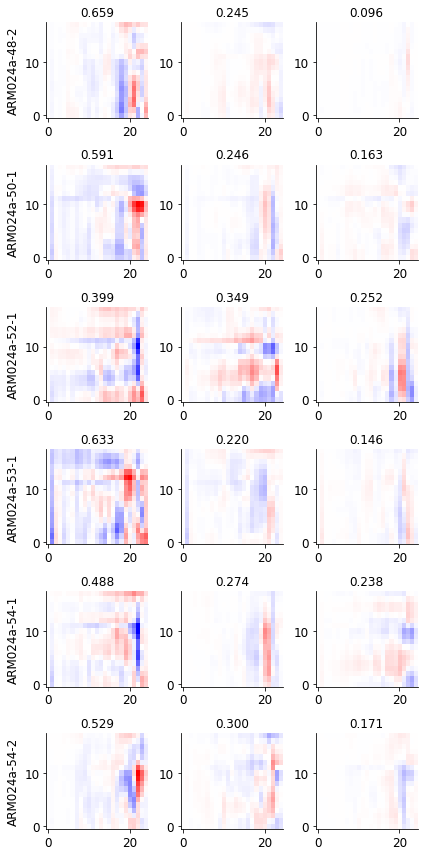

In [207]:
pcm = pc_mag/pc_mag.max(axis=0, keepdims=True)
imopts = {'interpolation': 'none', 'origin': 'lower', 'aspect': 'auto'}
f,ax = plt.subplots(len(out_channels), pc_count, figsize=(6,2*(len(out_channels))))
for i in range(pc_count):
    for j,out_channel in enumerate(out_channels):
        vmax = np.max(np.abs(pcs[j, :, :, :]))
        #ax[j,i].imshow(pcs[j, i, :, :], vmin=-vmax, vmax=vmax, cmap='bwr', **imopts)
        ax[j,i].imshow(pcs[j, i, :, :]*pcm[i,j], vmin=-vmax, vmax=vmax, cmap='bwr', **imopts)
        ax[j,i].set_title(f'{pc_mag[i,j]:.3f}')
        ax[j,0].set_ylabel(modelspec.meta['cellids'][out_channel])
plt.tight_layout()

In [208]:
coefficients = np.reshape(pcs, (pcs.shape[0]*pcs.shape[1], pcs.shape[2], pcs.shape[3]))
coefficients = np.moveaxis(coefficients, [2,1], [0,1])
coefficients = np.flip(coefficients, axis=0)
coefficients.shape, stim.shape, pred.shape

((25, 18, 18), (9600, 18), (9600, 46))

In [209]:
pcm[np.newaxis,:,0]

array([[1.        , 0.37203539, 0.14556297]])

(9600, 6, 3)


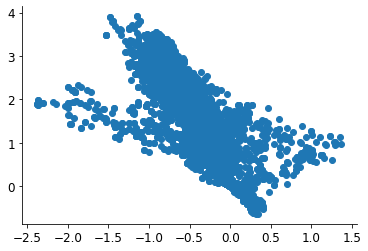

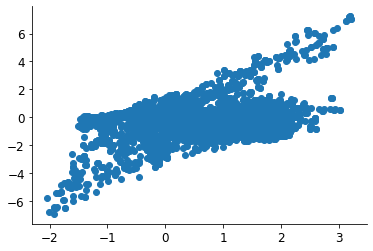

In [210]:
from nems.layers import FiniteImpulseResponse
from sklearn.decomposition import PCA

L = FiniteImpulseResponse(shape=(coefficients.shape))
L.set_parameter_values({'coefficients': coefficients})

Y = L.evaluate(stim)
Y = np.reshape(Y, (Y.shape[0], pcs.shape[0], pcs.shape[1]))
print(Y.shape)
Yp = np.zeros_like(Y)

yp = PCA(n_components=pc_count, whiten=True)
for j in range(Y.shape[1]):
    Yp[:,j,:]=yp.fit_transform(Y[:,j,:]*pcm[np.newaxis,:,j])
plt.figure()
plt.scatter(Y[:,0,0], Y[:,0,1])
plt.figure()
plt.scatter(Yp[:,0,0], Yp[:,0,1])
#Y0=Y.copy()
#Y=Yp

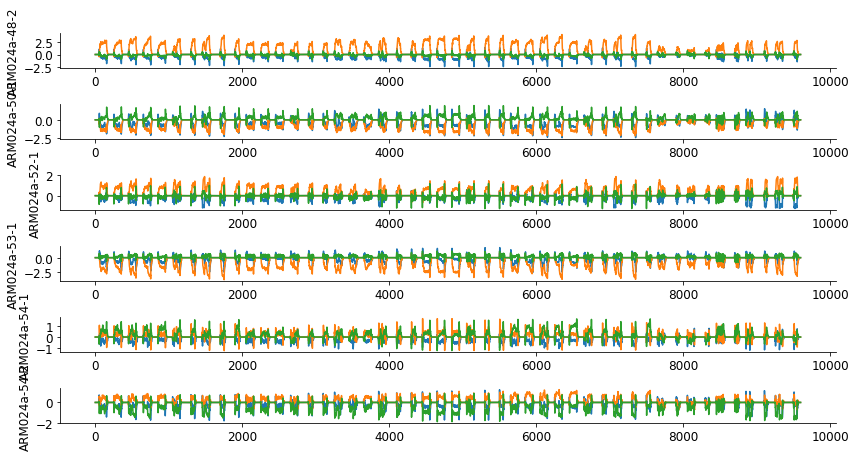

In [211]:
f,ax = plt.subplots(len(out_channels), 1, figsize=(12,6))
for j,out_channel in enumerate(out_channels):
    ax[j].plot(Y[:,j,:])
    ax[j].set_ylabel(modelspec.meta['cellids'][out_channel])
plt.tight_layout()

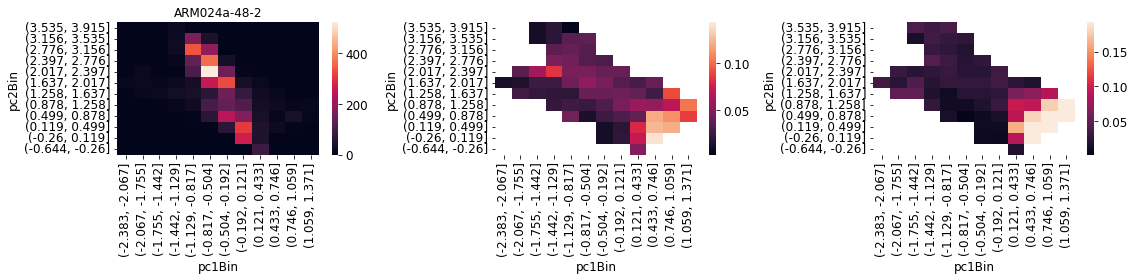

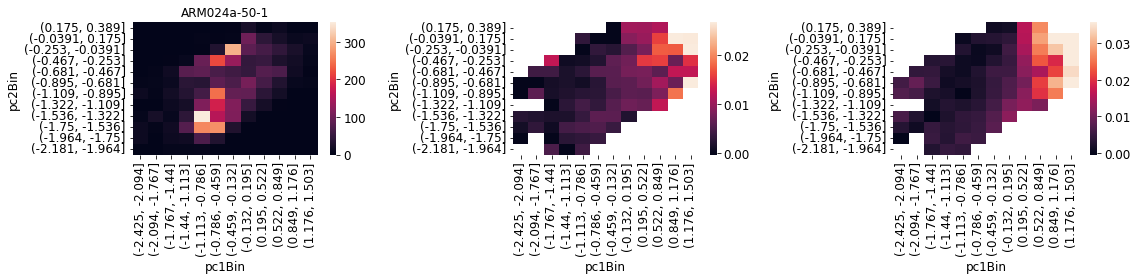

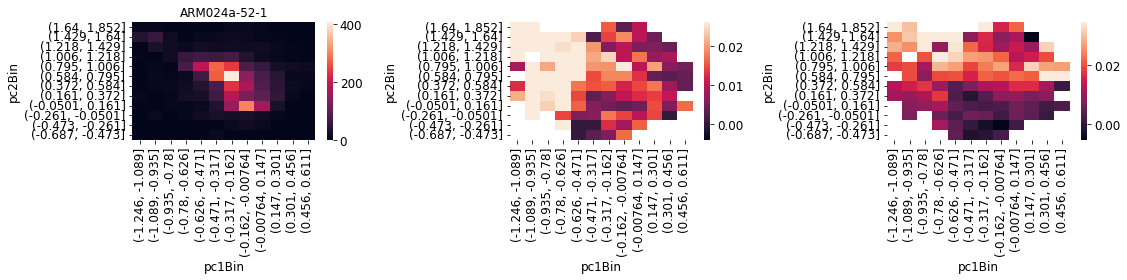

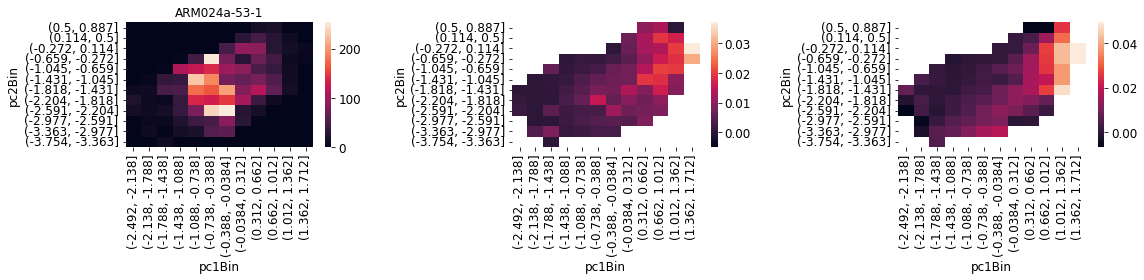

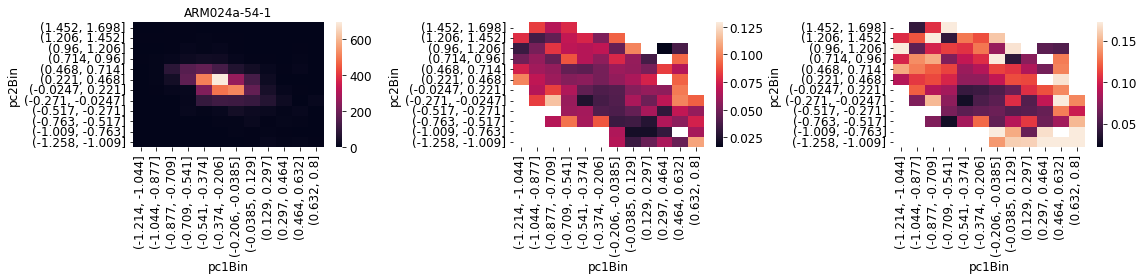

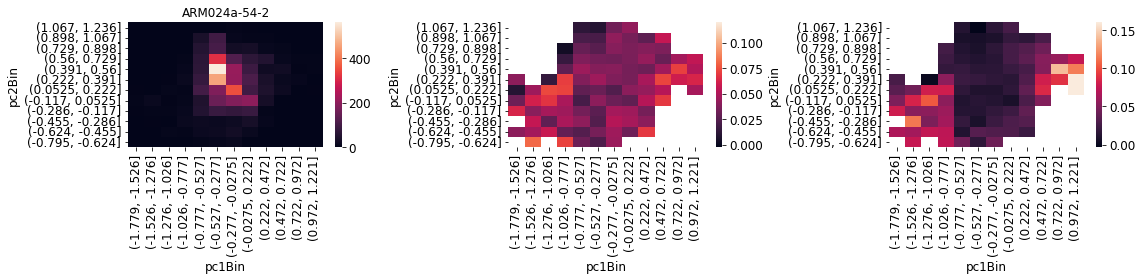

In [212]:
for j,out_channel in enumerate(out_channels):

    mag=np.sum(np.abs(Y0[:,j,:]), axis=1)
    i_ = mag>0.02

    d = pd.DataFrame({'pc1': Y[i_,j,0], 'pc2': Y[i_,j,1], 'pc3': Y[i_,j,2], 'pred': pred[i_,out_channel], 'resp': resp[i_,out_channel]})

    nCut = 12
    cuts = pd.DataFrame({feature + 'Bin' : pd.cut(d[feature], nCut) for feature in ['pc1','pc2']})

    means = d.join(cuts).groupby( list(cuts) ).mean()
    means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.
    N = d.join(cuts).groupby( list(cuts) ).count()
    N = N.unstack(level = 0) # Use level 0 to put 0Bin as columns.

    # Reverse the order of the rows as the heatmap will print from top to bottom.
    means = means.iloc[::-1]
    N = N.iloc[::-1]
    #means.head()
    #means['resp')
    vmin = np.nanmin(means['pred'].values) * 0.75
    vmax = np.nanmax(means['pred'].values) * 0.75
    
    f,ax=plt.subplots(1,3, figsize=(16,4))
    sns.heatmap(N['resp'], ax=ax[0])
    sns.heatmap(means['resp'], ax=ax[1], vmin=vmin*0.75, vmax=vmax*0.75)
    sns.heatmap(means['pred'], ax=ax[2], vmin=vmin, vmax=vmax)
    
    ax[0].set_title(modelspec.meta['cellids'][out_channel])
    plt.tight_layout()

In [197]:
def scatter_bin_lin(x, y, bins=10, max_points=1000, color='lightgray', color2=None, ax=None, regular_bins=True, include_scatter=True):
    
    #if data.shape[0]>max_points:
    #    data_ = data.sample(max_points, weights=data[x]**2)
    #else:
    #    data_ = data
    if include_scatter:
        ax.scatter(x=x, y=y, s=3, color=color)
    
    #D = data_[[x,y]].values
    D=np.stack((x,y),axis=1)
    if regular_bins:
        bb=np.linspace(D[:,0].min(), D[:,0].max(), bins+5);
        bb=bb[np.concatenate((np.arange(bins-1), [bins+1, bins+4])) ]
    else:
        xs=np.sort(D[:,0])
        xs[-1]+=1
        bb=xs[np.round(np.linspace(0, len(xs)-1, bins+1)).astype(int)]

    result = np.zeros((2,bins))
    resulte = np.zeros((2,bins))
    for i in range(bins):
        b_ = (D[:,0]>=bb[i]) & (D[:,0]<bb[i+1]) & np.isfinite(D[:,1])
        result[:,i] = np.nanmean(D[b_, :], axis=0)
        resulte[:,i] = np.nanstd(D[b_, :], axis=0)/np.sqrt(np.sum(b_))
    ax.errorbar(result[0], result[1], resulte[1], color=color2)
    

/tmp/ipykernel_1783289/708486886.py:24: RuntimeWarning: Mean of empty slice
  result[:,i] = np.nanmean(D[b_, :], axis=0)
/home/svd/bin/miniconda3/envs/nems/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


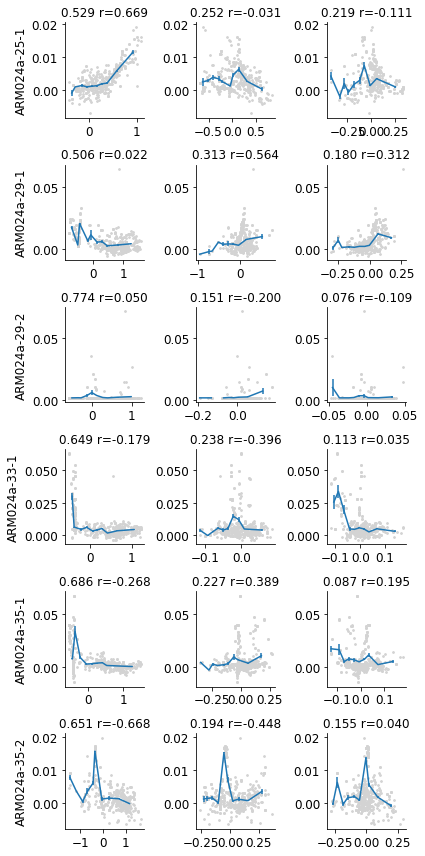

In [142]:
f,ax = plt.subplots(len(out_channels), pc_count, figsize=(6,2*(len(out_channels))))
for j,out_channel in enumerate(out_channels):
    for i in range(pc_count):
        scatter_bin_lin(Y[t_indexes,j,i], pred[t_indexes,out_channel], ax=ax[j,i])
        #ax[j,i].scatter(Y[t_indexes,j,i], resp[t_indexes,out_channel], s=2)
        r=np.corrcoef(Y[:,j,i], pred[:,out_channel])[0,1]
        ax[j,i].set_title(f'{pc_mag[i,j]:.3f} r={r:.3f}')
        
    ax[j,0].set_ylabel(modelspec.meta['cellids'][out_channel])
plt.tight_layout()

In [135]:
modelspec.dstrf_backend.model.summary()

Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 25, 18)]          0         
                                                                 
 wc (WeightChannelsGaussianT  (None, 25, 1, 70)        140       
 F)                                                              
                                                                 
 fir (FiniteImpulseResponseT  (None, 25, 70)           1050      
 F)                                                              
                                                                 
 relu (RectifiedLinearTF)    (None, 25, 70)            210       
                                                                 
 wc0 (WeightChannelsTF)      (None, 25, 1, 80)         5600      
                                                                 
 fir0 (FiniteImpulseResponse  (None, 25, 80)          

### Specify cell/batch/model

In [75]:
batch=328
cellid="ARM013b"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x100.g-fir.1x25x100-relu.100.f-wc.100x120-relu.120.f-wc.120xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4.ver2"
modelname="ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x6.g-fir.1x25x6-relu.6.f-wc.6x1-lvl.1-dexp.1_tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4.ver2"
modelname="ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x80.g-fir.1x15x80-relu.80.f-wc.80x90-fir.1x10x90-relu.90.f-wc.90x120-relu.120-wc.120xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4.ver2"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x80.g-fir.1x25x80-relu.80.f-wc.80x100-relu.100.f-wc.100xR-lvl.R-dexp.R_prefit.b322-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"

batch=333
cellid="HOD007a"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
cellid="TBR008a"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
modelname = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4"

cellid="ALLCELLS"

modelname = "ozgf.fs100.ch18.pop-loadpop-norm.l1-sev_wc.18x90.g-fir.1x15x90-relu.90.f-wc.90x100-fir.1x10x100-relu.100.f-wc.100x160-relu.160-wc.160xR-lvl.R-dexp.R_tfinit.n.mc50.lr1e3.et4.es20-newtf.n.mc100.lr1e4"

batch=333
cellid="HOD005b-01-1"
modelname='ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4'

cellid='ARM031a'
cellid="CLT049c-053-1"
cellid="ARM031a-12-1"
cellid="CLT049c-052-1"
batch=341
modelname='gtgram.fs100.ch18-ld.pop-norm.l1-sev.fOLP_wc.Nx100.g-fir.1x20x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit_tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4'
modelname="gtgram.fs100.ch18-ld.pop-norm.l1-sev.fOLP_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x100-fir.1x10x100-relu.100.f-wc.100x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
#modelname="gtgram.fs100.ch18-ld.pop-norm.l1-sev.fOLP_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x100-fir.1x10x100-relu.100.f-wc.100x100-relu.100-wc.100xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
modelname="gtgram.fs100.ch18-ld.pop-norm.l1-sev.fOLP_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
modelname="gtgram.fs100.ch18-ld.pop-norm.l1-sev.fOLP_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322.f.nf-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"

In [1]:
from nems0.xform_helper import load_model_xform
cellid="CLT049c-052-1"
batch=341
modelname="gtgram.fs100.ch18-ld.pop-norm.l1-sev.fOLP_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322.f.nf-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
xf,ctx=load_model_xform(cellid=cellid,batch=batch,modelname=modelname)

[numexpr.utils INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils INFO] NumExpr defaulting to 8 threads.
[nems0.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/341/CLT049c/gtgram.fs100.ch18-ld.pop-norm.l1-sev.fOLP.wc.18x70.g-fir.1x15x70-relu.70.f-wc.70...4539438319552198613 ...
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] xf argument cellid overlaps with existing context key: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.load_recordings
[nems0.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/341/CLT049c_aeedaddc922c82b56e7ea4c26d28a141ea3e447e.tgz to /auto/data/nems_db/recordings/341/CLT049c_aeedaddc922c82b56e7ea4c26d28a141ea3e447e.tgz
[nems0.xforms INFO] Extracting cellid(s) ['CLT049c-020-1', 'CLT049c-022-1', 'CLT049c-023-1', 'CLT049c-026-1', 'CLT049c-027-1', 'C

In [76]:
xf,ctx=load_model_xform(cellid=cellid,batch=batch,modelname=modelname)

[nems0.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/341/CLT049c/gtgram.fs100.ch18-ld.pop-norm.l1-sev.fOLP.wc.18x70.g-fir.1x15x70-relu.70.f-wc.70...4539438319552198613 ...
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] xf argument cellid overlaps with existing context key: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.load_recordings
[nems0.utils INFO] Adjusting URI from http://hyrax.ohsu.edu:3003/recordings/341/CLT049c_aeedaddc922c82b56e7ea4c26d28a141ea3e447e.tgz to /auto/data/nems_db/recordings/341/CLT049c_aeedaddc922c82b56e7ea4c26d28a141ea3e447e.tgz
[nems0.xforms INFO] Extracting cellid(s) ['CLT049c-020-1', 'CLT049c-022-1', 'CLT049c-023-1', 'CLT049c-026-1', 'CLT049c-027-1', 'CLT049c-028-1', 'CLT049c-028-2', 'CLT049c-029-1', 'CLT049c-033-1', 'CLT049c-033-2', 'CLT049c-033-3', 'CLT049c-034-1', 'CLT049c-034-2', 'CLT049c-036-1', 'CLT049c-038-1', 'CLT

In [81]:
e=ctx['val']['resp'].epochs
e.name[e.name.str.startswith('STIM')]

2      STIM_06Stream-0-1-1-A_01FightSqueak-0-1-1-A
6         STIM_06Stream-0-1-1-A_25Chickens-0-1-1-A
10       STIM_06Stream-0-1-1-A_34Castinets-0-1-1-A
14            STIM_06Stream-0-1-1-A_38ManA-0-1-1-A
18                      STIM_06Stream-0-1-1-A_null
                          ...                     
654                       STIM_null_38ManA-0-1-1-M
658                       STIM_null_38ManA-0-1-1-N
662                       STIM_null_38ManA-0-1-1-S
666                       STIM_null_38ManA-0-1-1-T
670                       STIM_null_38ManA-0-1-1-U
Name: name, Length: 168, dtype: object

In [82]:
ctx['val']['pred'].chans = ctx['val']['resp'].chans
dfr = generate_cc_dataframe(ctx['val'], rsignal='resp',force_mua_only=False)
dfp = generate_cc_dataframe(ctx['val'], rsignal='pred',force_mua_only=False)
dfr = dfr.merge(dfp[['BG + FG','cellid','dd']], left_on=['BG + FG', 'cellid'], right_on=['BG + FG','cellid'], suffixes=('','_p'))
#dfr = dfr.loc[dfr['BG + FG'].str.endswith('-U')]

CLT049c-020-1
CLT049c-022-1
CLT049c-023-1
CLT049c-026-1
CLT049c-027-1
CLT049c-028-1
CLT049c-028-2
CLT049c-029-1
CLT049c-033-1
CLT049c-033-2
CLT049c-033-3
CLT049c-034-1
CLT049c-034-2
CLT049c-036-1
CLT049c-038-1
CLT049c-041-1
CLT049c-045-1
CLT049c-046-1
CLT049c-047-1
CLT049c-048-1
CLT049c-049-1
CLT049c-050-1
CLT049c-052-1
CLT049c-053-1
CLT049c-054-1
CLT049c-054-2
CLT049c-055-1
CLT049c-056-1
CLT049c-020-1
CLT049c-022-1
CLT049c-023-1
CLT049c-026-1
CLT049c-027-1
CLT049c-028-1
CLT049c-028-2
CLT049c-029-1
CLT049c-033-1
CLT049c-033-2
CLT049c-033-3
CLT049c-034-1
CLT049c-034-2
CLT049c-036-1
CLT049c-038-1
CLT049c-041-1
CLT049c-045-1
CLT049c-046-1
CLT049c-047-1
CLT049c-048-1
CLT049c-049-1
CLT049c-050-1
CLT049c-052-1
CLT049c-053-1
CLT049c-054-1
CLT049c-054-2
CLT049c-055-1
CLT049c-056-1


In [83]:
dfr.shape

(3136, 25)

array([[1.        , 0.34010597],
       [0.34010597, 1.        ]])

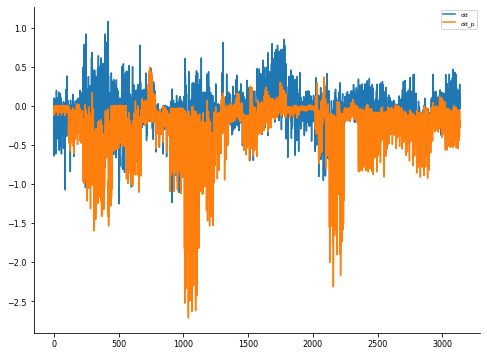

In [84]:
#plt.figure()
dfr[['dd','dd_p']].plot()
np.corrcoef(dfr[['dd']].values.T,dfr[['dd_p']].values.T)

In [21]:
dfr

,index,BG + FG,BG,FG,Synth Type,Binaural Type,cellid,cbb,cff,crfb,...,Eb,Ef,E,cff+cbb,cff-cbb,(crfbf-crbbf),FG cc(both-sum),BG cc(both-sum),dd,ddraw
0,0,STIM_03Insect_Buzz-0-1_01Fight_Squeak-0-1,STIM_03Insect_Buzz-0-1_null,STIM_null_01Fight_Squeak-0-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.939887,0.817672,0.848065,...,True,True,True,0.878780,-0.122216,-0.002496,-0.111321,-0.114377,0.003056,0.000560
1,1,STIM_03Insect_Buzz-0-1_01Fight_Squeak-0.5-1,STIM_03Insect_Buzz-0-1_null,STIM_null_01Fight_Squeak-0.5-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.939887,0.874986,0.479755,...,True,True,True,0.907437,-0.064901,-0.047032,-0.409219,0.033284,-0.442503,-0.489535
2,2,STIM_03Insect_Buzz-0-1_04Gobble-0-1,STIM_03Insect_Buzz-0-1_null,STIM_null_04Gobble-0-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.939887,0.932381,0.937138,...,True,True,True,0.936134,-0.007506,0.002075,-0.001120,-0.010469,0.009349,0.011425
3,3,STIM_03Insect_Buzz-0-1_04Gobble-0.5-1,STIM_03Insect_Buzz-0-1_null,STIM_null_04Gobble-0.5-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.939887,0.954438,0.479509,...,True,True,True,0.947163,0.014551,-0.021541,-0.264537,0.105328,-0.369865,-0.391406
4,4,STIM_03Insect_Buzz-0-1_05Kit_Groan-0-1,STIM_03Insect_Buzz-0-1_null,STIM_null_05Kit_Groan-0-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.939887,0.729813,0.836406,...,True,True,True,0.834850,-0.210074,-0.025548,-0.057130,0.018031,-0.075161,-0.100710
5,5,STIM_03Insect_Buzz-0-1_05Kit_Groan-0.5-1,STIM_03Insect_Buzz-0-1_null,STIM_null_05Kit_Groan-0.5-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.939887,0.817122,0.444341,...,True,True,True,0.878505,-0.122765,-0.121358,-0.264231,0.074450,-0.338681,-0.460039
6,6,STIM_03Insect_Buzz-0.5-1_01Fight_Squeak-0-1,STIM_03Insect_Buzz-0.5-1_null,STIM_null_01Fight_Squeak-0-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.963979,0.817672,0.510885,...,True,True,True,0.890825,-0.146307,0.025817,0.076116,-0.343342,0.419458,0.445275
7,7,STIM_03Insect_Buzz-0.5-1_01Fight_Squeak-0.5-1,STIM_03Insect_Buzz-0.5-1_null,STIM_null_01Fight_Squeak-0.5-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.963979,0.874986,0.954795,...,True,True,True,0.919483,-0.088992,-0.000745,-0.047358,-0.059345,0.011987,0.011242
8,8,STIM_03Insect_Buzz-0.5-1_04Gobble-0-1,STIM_03Insect_Buzz-0.5-1_null,STIM_null_04Gobble-0-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.963979,0.932381,0.590826,...,True,True,True,0.948180,-0.031597,0.043049,0.079256,-0.268834,0.348090,0.391139
9,9,STIM_03Insect_Buzz-0.5-1_04Gobble-0.5-1,STIM_03Insect_Buzz-0.5-1_null,STIM_null_04Gobble-0.5-1,Non-RMS Unsynthetic,"BG Contra, FG Contra",ARM031a-12-1,0.963979,0.954438,0.980087,...,True,True,True,0.959208,-0.009541,0.000522,-0.005947,0.001244,-0.007191,-0.006669


# fit_xforms_model code

high-level options

In [3]:
autoPlot = True
saveInDB = False
browse_results = False
saveFile = False

log.info('Initializing modelspec(s) for cell/batch %s/%d...', cellid, int(batch))

# Segment modelname for meta information
kws = modelname.split("_")
modelspecname = "-".join(kws[1:-1])
loadkey = kws[0]
fitkey = kws[-1]

meta = {'batch': batch, 'cellid': cellid, 'modelname': modelname,
        'loader': loadkey, 'fitkey': fitkey, 'modelspecname': modelspecname,
        'username': 'nems', 'labgroup': 'lbhb', 'public': 1,
        'githash': os.environ.get('CODEHASH', ''),
        'recording': loadkey}

[__main__ INFO] Initializing modelspec(s) for cell/batch HOD005b-01-1/333...


Generate xfspec

In [4]:
xforms_kwargs = {}
xforms_init_context = {'cellid': cellid, 'batch': int(batch)}
recording_uri = None
kw_kwargs ={}

# equivalent of xform_helper.generate_xforms_spec():

# parse modelname and assemble xfspecs for loader and fitter
load_keywords, model_keywords, fit_keywords = escaped_split(modelname, '_')

# Generate the xfspec, which defines the sequence of events
# to run through (like a packaged-up script)

# 0) set up initial context
if xforms_init_context is None:
    xforms_init_context = {}
if kw_kwargs is not None:
     xforms_init_context['kw_kwargs'] = kw_kwargs
xforms_init_context['keywordstring'] = model_keywords
xforms_init_context['meta'] = meta
xforms_lib.kwargs = xforms_init_context.copy()

xfspec = [['nems0.xforms.init_context', xforms_init_context]]

# 1) Load the data
xfspec.extend(xhelp._parse_kw_string(load_keywords, xforms_lib))

# 2) generate a modelspec
xfspec.append(['nems0.xforms.init_from_keywords', {'registry': keyword_lib}])

# 3) fit the data
xfspec.extend(xhelp._parse_kw_string(fit_keywords, xforms_lib))

# 4) add some performance statistics
if not _xform_exists(xfspec, 'nems0.xforms.predict'):
    xfspec.append(['nems0.xforms.predict', {}])

# 5) add some performance statistics (optional)
if not _xform_exists(xfspec, 'nems0.xforms.add_summary_statistics'):
    xfspec.append(['nems0.xforms.add_summary_statistics', {}])

# 6) generate plots (optional)
if autoPlot and not _xform_exists(xfspec, 'nems0.xforms.plot_summary'):
    xfspec.append(['nems0.xforms.plot_summary', {}])

[nems_lbhb.xform_wrappers INFO] loader=ozgf.fs100.ch18
[numexpr.utils INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils INFO] NumExpr defaulting to 8 threads.
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/333/HOD005b_ffddbd8ba57a049bed7ac52746035ec2a4a97307.tgz


In [5]:
len(xfspec)
xfspec[1]

['nems0.xforms.init_context',
 {'recording_uri_list': ['/auto/data/nems_db/recordings/333/HOD005b_ffddbd8ba57a049bed7ac52746035ec2a4a97307.tgz'],
  'cellid': ['HOD005b-01-1']}]

equivalent of xforms.evaluate():

[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] xf argument cellid overlaps with existing context key: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.load_recordings
[nems0.xforms INFO] Extracting cellid(s) ['HOD005b-01-1']
[nems0.preprocessing INFO] Adding to epoch_onsets: TRIAL with shift = 0
[nems0.xforms INFO] Evaluating: nems0.xforms.normalize_sig
[nems0.xforms INFO] xforms.normalize_sig: stim b=0.0, g=5.441876601479855, dlog(..., -1)
[nems0.xforms INFO] Evaluating: nems0.xforms.normalize_sig
[nems0.xforms INFO] xforms.normalize_sig: resp b=0.0, g=6.0, dlog(..., -None)
[nems0.xforms INFO] Evaluating: nems0.xforms.split_by_occurrence_counts
[nems0.xforms INFO] Evaluating: nems0.xforms.average_away_stim_occurrences
[nems0.xforms INFO] Evaluating: nems0.xforms.init_from_keywords
[nems0.initializers INFO] kw: wc.18x70.g
[nems0.initializers INFO] kw: fir.1x15x70
[nems0.initia

Epoch 00001/10000 - loss: 69.5783 - pearson: 0.5607 - val_loss: 92.5661 - val_pearson: 0.3391
Epoch 00050/10000 - loss: 0.1851 - pearson: 0.8279 - val_loss: 0.3660 - val_pearson: 0.6843
Epoch 00100/10000 - loss: 0.1713 - pearson: 0.8436 - val_loss: 0.3445 - val_pearson: 0.7047
Epoch 00150/10000 - loss: 0.1613 - pearson: 0.8485 - val_loss: 0.3484 - val_pearson: 0.7154
Epoch 00200/10000 - loss: 0.1588 - pearson: 0.8507 - val_loss: 0.3623 - val_pearson: 0.7186
Epoch 00250/10000 - loss: 0.1620 - pearson: 0.8517 - val_loss: 0.3734 - val_pearson: 0.7246
Epoch 00300/10000 - loss: 0.1578 - pearson: 0.8515 - val_loss: 0.3417 - val_pearson: 0.7159


[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_basic to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift to modelspec phis.
[nems0.tf.cnnlink_new INFO] Special case of freezing: restoring truncated model!!!
[nems0.initializers INFO] Updating modules 8 to 10 in modelspec_original


Restoring model weights from the end of the best epoch.
Epoch 00315: early stopping


[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 7.008142438214825e-09
[nems0.tf.cnnlink_new INFO] Initializing static nl "nems0.modules.nonlinearity.double_exponential" at layer #10
[nems0.initializers INFO] Init dexp: {'amplitude': array([[0.19167003]]), 'base': array([[-0.00754905]]), 'kappa': array([[0.]]), 'shift': array([[0.]])}
[nems0.tf.cnnlink_new INFO] Running second init fit: force_freeze: [0, 1, 2, 3, 4, 5, 6, 7].
[nems0.tf.cnnlink_new INFO] Building tensorflow keras model from modelspec.
[nems0.tf.cnnlink_new INFO] Special case of freezing: truncating model!!!
[nems0.tf.cnnlink_new INFO] Feature dimensions: (70, 200, 100); Data dimensions: (70, 200, 1).
[nems0.tf.cnnlink_new INFO] adding a tiny bit of noise to resp_train
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.weight_channels.basic".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.levelshift.levelshift".
[nems0.tf.layers INFO] Building tf layer for "nems0.mod

Epoch 00001/10000 - loss: 0.6192 - pearson: 0.8485 - val_loss: 1.0207 - val_pearson: 0.7205
Epoch 00050/10000 - loss: 0.2501 - pearson: 0.7599 - val_loss: 0.3850 - val_pearson: 0.6430
Epoch 00100/10000 - loss: 0.2029 - pearson: 0.8076 - val_loss: 0.3272 - val_pearson: 0.7052
Epoch 00150/10000 - loss: 0.1735 - pearson: 0.8365 - val_loss: 0.3038 - val_pearson: 0.7334
Epoch 00200/10000 - loss: 0.1587 - pearson: 0.8502 - val_loss: 0.2967 - val_pearson: 0.7459
Epoch 00250/10000 - loss: 0.1533 - pearson: 0.8562 - val_loss: 0.2967 - val_pearson: 0.7520
Epoch 00300/10000 - loss: 0.1509 - pearson: 0.8568 - val_loss: 0.2927 - val_pearson: 0.7561
Epoch 00350/10000 - loss: 0.1500 - pearson: 0.8593 - val_loss: 0.2894 - val_pearson: 0.7586
Epoch 00400/10000 - loss: 0.1497 - pearson: 0.8580 - val_loss: 0.2851 - val_pearson: 0.7601
Epoch 00450/10000 - loss: 0.1491 - pearson: 0.8598 - val_loss: 0.2875 - val_pearson: 0.7615
Epoch 00500/10000 - loss: 0.1478 - pearson: 0.8612 - val_loss: 0.2847 - val_pear

[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_basic_1 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_1 to modelspec phis.
[nems0.tf.layers INFO] Converted double_exponential to modelspec phis.
[nems0.tf.cnnlink_new INFO] Special case of freezing: restoring truncated model!!!
[nems0.initializers INFO] Updating modules 8 to 11 in modelspec_original


Restoring model weights from the end of the best epoch.
Epoch 00834: early stopping


[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 8.701973369464051e-09
[nems0.xforms INFO] Evaluating: nems0.xforms.fit_wrapper
[nems0.xforms INFO] ----------------------------------------------------
[nems0.xforms INFO] Fitting: nems0.tf.cnnlink_new.fit_tf, fit 1/1, fold 1/1
[nems0.tf.cnnlink_new INFO] Building tensorflow keras model from modelspec.
[nems0.tf.cnnlink_new INFO] Special case of freezing: truncating model!!!
[nems0.tf.cnnlink_new INFO] Feature dimensions: (70, 200, 100); Data dimensions: (70, 200, 1).
[nems0.tf.cnnlink_new INFO] adding a tiny bit of noise to resp_train
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.weight_channels.basic".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.levelshift.levelshift".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.nonlinearity.double_exponential".
[nems0.tf.modelbuilder INFO] Built model, printing summary.
[nems0.tf.modelbuilder INFO] Model: "Test-model"
[nems

Epoch 00001/10000 - loss: 0.1668 - pearson: 0.8386
Epoch 00050/10000 - loss: 0.1647 - pearson: 0.8618
Epoch 00100/10000 - loss: 0.1615 - pearson: 0.8602
Epoch 00150/10000 - loss: 0.1607 - pearson: 0.8531
Epoch 00200/10000 - loss: 0.1611 - pearson: 0.8543
Epoch 00250/10000 - loss: 0.1607 - pearson: 0.8454
Epoch 00300/10000 - loss: 0.1609 - pearson: 0.8572
Epoch 00350/10000 - loss: 0.1604 - pearson: 0.8547
Restoring model weights from the end of the best epoch.
Epoch 00358: early stopping


[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_basic_2 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_2 to modelspec phis.
[nems0.tf.layers INFO] Converted double_exponential_1 to modelspec phis.
[nems0.tf.cnnlink_new INFO] Special case of freezing: restoring truncated model!!!
[nems0.initializers INFO] Updating modules 8 to 11 in modelspec_original
[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 8.643541731061816e-09
[nems0.xforms INFO] Evaluating: nems0.xforms.predict
[nems0.xforms INFO] Evaluating: nems0.xforms.add_summary_statistics
[nems0.xforms INFO] cell_index: 0
[nems0.xforms INFO] Evaluating: nems0.xforms.plot_summary
[nems0.modelspec INFO] Quickplot: no epoch specified, falling back to "REFERENCE"
[nems0.modelspec INFO] plotting row 1/7
[nems0.modelspec INFO] plotting row 2/7
[nems0.modelspec INFO] plotting row 3/7
[nems0.modelspec INFO] plotting row 4/7
[n

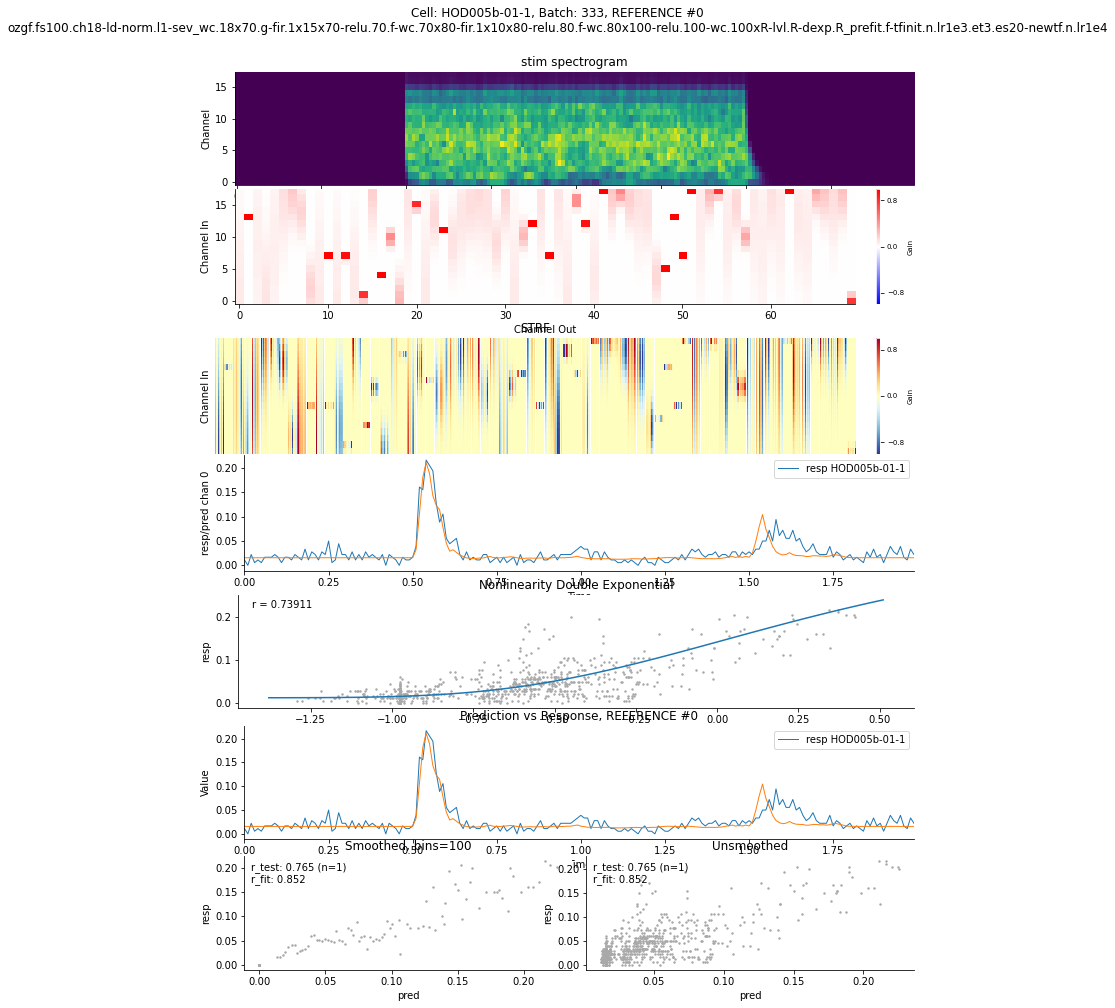

In [6]:
starttime=time.time()
# Create a log stream set to the debug level; add it as a root log handler
log_stream = io.StringIO()
ch = logging.StreamHandler(log_stream)
ch.setLevel(logging.DEBUG)
fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
formatter = logging.Formatter(fmt)
ch.setFormatter(formatter)
rootlogger = logging.getLogger()
rootlogger.addHandler(ch)

ctx = {}
for xfa in xfspec:
    if not('postprocess' in xfa[0]):
        ctx = xforms.evaluate_step(xfa, ctx)

# Close the log, remove the handler, and add the 'log' string to context
log.info('Done (re-)evaluating xforms.')
ch.close()
rootlogger.removeFilter(ch)

log_xf = log_stream.getvalue()

In [26]:
ctx['modelspec'].cell_index=2
ctx['modelspec'].cell_index, ctx['modelspec'].meta['r_test'].mean()

(2, 0.4722765082149491)

In [20]:
ctx['val_list'][2]['pred'].shape

(15, 1200)

In [15]:
ctx['modelspec'].fit_index=2
ctx['modelspec'].fit_index, ctx['modelspec'].meta['r_test'].mean(), ctx['modelspec'].meta['cellids'][:2]

(2, 0.5151746014041032, ['HOD005b-01-1', 'HOD005b-01-2'])

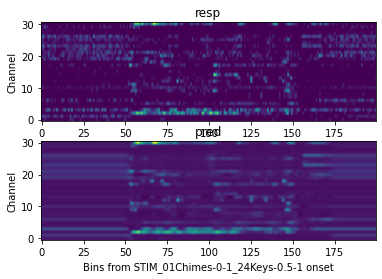

In [42]:
f,ax=plt.subplots(2,1)
ctx['est']['resp'].plot_epoch_avg('STIM_01Chimes-0-1_24Keys-0.5-1', ax=ax[0])
ctx['est']['pred'].plot_epoch_avg('STIM_01Chimes-0-1_24Keys-0.5-1', ax=ax[1])


In [48]:
ctx['modelspec'].meta['r_test'].mean()  #, ctx['modelspec'].meta['cellids']

0.3908738722088035

# Fit modelname2

[nems0.xform_helper INFO] Initializing modelspec(s) for cell/batch TBR008a/333...
[nems0.xform_helper INFO] TODO: simplify generate_xforms_spec parameters
[nems0.xform_helper INFO] Initializing modelspec(s) for recording/model None/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322.nf-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4...
[nems_lbhb.xform_wrappers INFO] loader=ozgf.fs100.ch18
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/333/TBR008a_67d10ac6c9689303e2891d6fc3b075efb8d07a70.tgz
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.init_context
[nems0.xforms INFO] xf argument cellid overlaps with existing context key: nems0.xforms.init_context
[nems0.xforms INFO] Evaluating: nems0.xforms.load_recordings
[nems0.xforms INFO] Extracting cellid(s) ['TBR008a-05-5', 'TBR008a-08-4', 'TBR008a-09-1', 'TBR008a-12-1'

Epoch 00001/10000 - loss: 62.1138 - pearson: 0.0736 - val_loss: 45.3646 - val_pearson: 0.1050
Epoch 00050/10000 - loss: 0.5480 - pearson: 0.5973 - val_loss: 0.5850 - val_pearson: 0.5441
Epoch 00100/10000 - loss: 0.5079 - pearson: 0.6085 - val_loss: 0.5629 - val_pearson: 0.5678
Epoch 00150/10000 - loss: 0.4903 - pearson: 0.6403 - val_loss: 0.5765 - val_pearson: 0.5581
Epoch 00200/10000 - loss: 0.4717 - pearson: 0.6739 - val_loss: 0.6089 - val_pearson: 0.5351
Epoch 00250/10000 - loss: 0.4564 - pearson: 0.7056 - val_loss: 0.5707 - val_pearson: 0.5707
Restoring model weights from the end of the best epoch.
Epoch 00262: early stopping


[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_gaussian to modelspec phis.
[nems0.tf.layers INFO] Converted fir to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_9 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_1 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_10 to modelspec phis.
[nems0.tf.layers INFO] Converted relu_2 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_11 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_9 to modelspec phis.
[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 4.222648007607044e-09
[nems0.tf.cnnlink_new INFO] Initializing static nl "nems0.modules.nonlinearity.double_exponential" at layer #10
[nems0.initializers INFO] Init dexp completed for 31 channels 
[nems0.tf.cnnlink_new INFO] Running second init fit: not frozen but coarser tolerance.
[nems0.tf.cnnlink_ne

Epoch 00001/10000 - loss: 0.8652 - pearson: 0.3822 - val_loss: 0.7713 - val_pearson: 0.4170
Epoch 00050/10000 - loss: 0.5479 - pearson: 0.5880 - val_loss: 0.5673 - val_pearson: 0.5596
Epoch 00100/10000 - loss: 0.5192 - pearson: 0.6003 - val_loss: 0.5501 - val_pearson: 0.5790
Epoch 00150/10000 - loss: 0.5011 - pearson: 0.6321 - val_loss: 0.5533 - val_pearson: 0.5754
Epoch 00200/10000 - loss: 0.4777 - pearson: 0.6587 - val_loss: 0.5576 - val_pearson: 0.5709
Epoch 00250/10000 - loss: 0.4564 - pearson: 0.6971 - val_loss: 0.5512 - val_pearson: 0.5801
Epoch 00300/10000 - loss: 0.4386 - pearson: 0.6217 - val_loss: 0.5529 - val_pearson: 0.5756


[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_gaussian_1 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_2 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_12 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_3 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_13 to modelspec phis.
[nems0.tf.layers INFO] Converted relu_5 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_14 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_10 to modelspec phis.
[nems0.tf.layers INFO] Converted double_exponential_6 to modelspec phis.


Restoring model weights from the end of the best epoch.
Epoch 00336: early stopping


[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 3.809460620432857e-09
[nems0.xforms INFO] Evaluating: nems0.xforms.fit_wrapper
[nems0.xforms INFO] ----------------------------------------------------
[nems0.xforms INFO] Fitting: nems0.tf.cnnlink_new.fit_tf, fit 1/1, fold 1/1
[nems0.tf.cnnlink_new INFO] Building tensorflow keras model from modelspec.
[nems0.tf.cnnlink_new INFO] Feature dimensions: (43, 200, 18); Data dimensions: (43, 200, 31).
[nems0.tf.cnnlink_new INFO] adding a tiny bit of noise to resp_train
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.weight_channels.gaussian".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.fir.filter_bank".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.nonlinearity.relu".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.weight_channels.basic".
[nems0.tf.layers INFO] Building tf layer for "nems0.modules.fir.filter_bank".
[nems0.tf.layers INFO] Building tf layer fo

Epoch 00001/10000 - loss: 0.4932 - pearson: 0.6435
Epoch 00050/10000 - loss: 0.4840 - pearson: 0.6420
Epoch 00100/10000 - loss: 0.4807 - pearson: 0.6611
Epoch 00150/10000 - loss: 0.4754 - pearson: 0.6666
Epoch 00200/10000 - loss: 0.4711 - pearson: 0.6546
Epoch 00250/10000 - loss: 0.4678 - pearson: 0.6622
Epoch 00300/10000 - loss: 0.4643 - pearson: 0.6587
Epoch 00350/10000 - loss: 0.4608 - pearson: 0.6687
Epoch 00400/10000 - loss: 0.4591 - pearson: 0.6836
Epoch 00450/10000 - loss: 0.4549 - pearson: 0.6708
Epoch 00500/10000 - loss: 0.4517 - pearson: 0.6634
Epoch 00550/10000 - loss: 0.4486 - pearson: 0.6866
Epoch 00600/10000 - loss: 0.4470 - pearson: 0.6638
Epoch 00650/10000 - loss: 0.4434 - pearson: 0.6775
Epoch 00700/10000 - loss: 0.4437 - pearson: 0.6997
Epoch 00750/10000 - loss: 0.4373 - pearson: 0.6879
Epoch 00800/10000 - loss: 0.4357 - pearson: 0.6978
Epoch 00850/10000 - loss: 0.4309 - pearson: 0.7048
Epoch 00900/10000 - loss: 0.4323 - pearson: 0.7065
Epoch 00950/10000 - loss: 0.427

[nems0.tf.cnnlink_new INFO] Populating modelspec with model weights.
[nems0.tf.layers INFO] Converted weight_channels_gaussian_2 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_4 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_15 to modelspec phis.
[nems0.tf.layers INFO] Converted fir_5 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_16 to modelspec phis.
[nems0.tf.layers INFO] Converted relu_8 to modelspec phis.
[nems0.tf.layers INFO] Converted weight_channels_basic_17 to modelspec phis.
[nems0.tf.layers INFO] Converted levelshift_11 to modelspec phis.
[nems0.tf.layers INFO] Converted double_exponential_7 to modelspec phis.


Restoring model weights from the end of the best epoch.
Epoch 02262: early stopping


[nems0.tf.cnnlink_new INFO] Mean difference between NEMS and TF model prediction: 9.75774164544199e-09
[nems0.xforms INFO] Evaluating: nems0.xforms.predict
[nems0.xforms INFO] Evaluating: nems0.xforms.add_summary_statistics
[nems0.xforms INFO] cell_index: 0
[nems0.xforms INFO] Evaluating: nems0.xforms.plot_summary
[nems0.modelspec INFO] Quickplot: no epoch specified, falling back to "REFERENCE"
[nems0.modelspec INFO] plotting row 1/7
[nems0.modelspec INFO] plotting row 2/7
[nems0.modelspec INFO] plotting row 3/7
[nems0.modelspec INFO] plotting row 4/7
[nems0.modelspec INFO] plotting row 5/7
[nems0.plots.scatter WARNING] corr coef expects single-dim predictions
[nems0.plots.scatter WARNING] sig1 or sig2 chancount > 1, using chan 0
[nems0.modelspec INFO] plotting row 6/7
[nems0.modelspec INFO] plotting row 7/7
[nems0.plots.scatter WARNING] sig1 or sig2 chancount > 1, using chan 0
[nems0.modelspec INFO] Quickplot: generated fig with title "Cell: TBR008a, Batch: 333, REFERENCE #0 ozgf.fs10

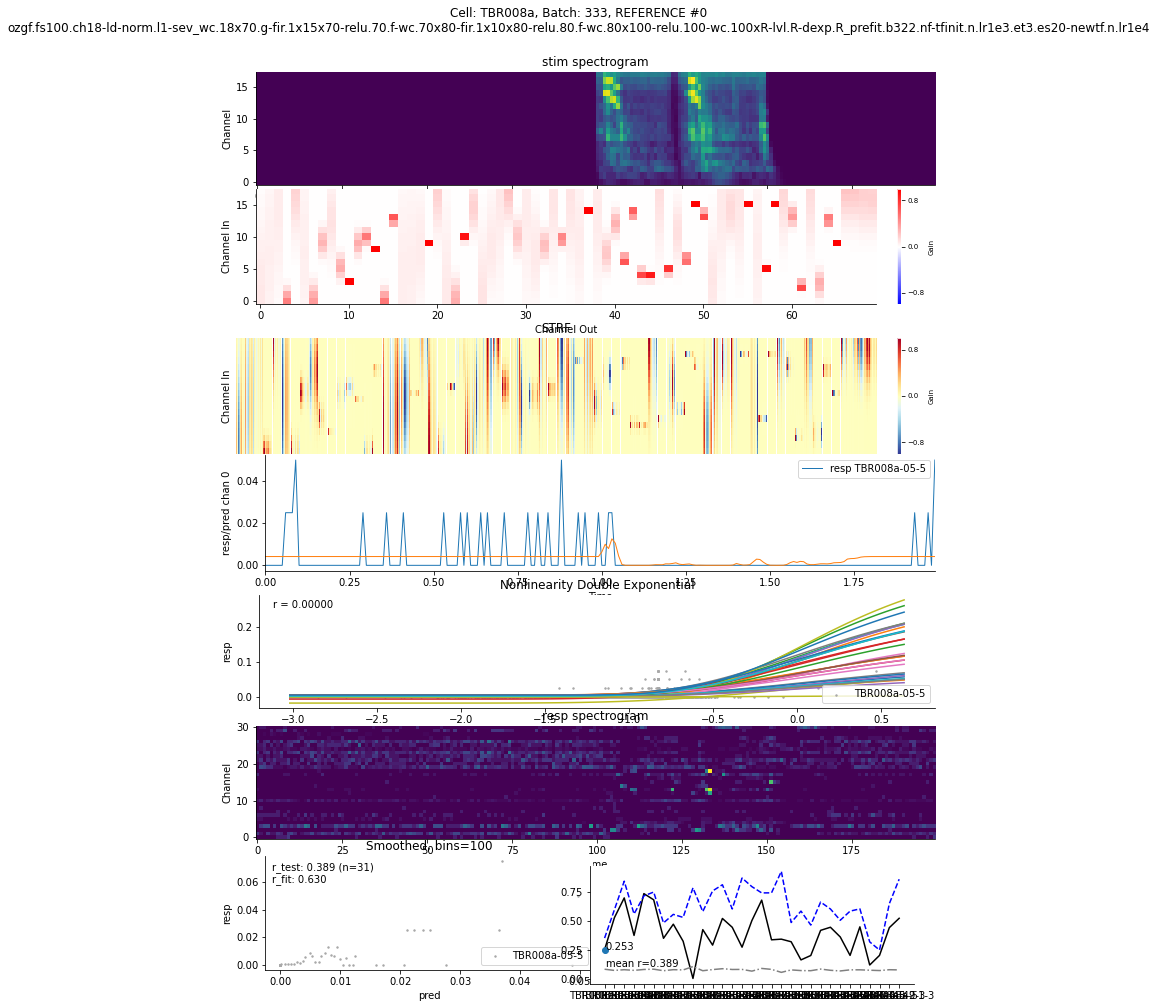

In [31]:
cellid="TBR008a"
modelname2 = "ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.b322.nf-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"

xfspec2, ctx2=fit_model_xform(cellid, batch, modelname2, returnModel=True)

In [45]:
ctx2['modelspec'].meta['r_test'].mean()  #, ctx2['modelspec'].meta['cellids']

0.38947379673596755

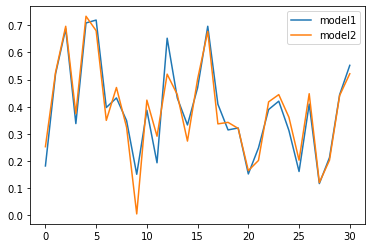

In [44]:
plt.figure()
plt.plot(ctx['modelspec'].meta['r_test'],label='model1')
plt.plot(ctx2['modelspec'].meta['r_test'],label='model2')
plt.legend()

# pooled OLP

In [7]:
from nems_lbhb.projects.pop_model_scripts.pop_model_utils import load_string_pop, fit_string_pop, load_string_single, fit_string_single,\
    POP_MODELS, SIG_TEST_MODELS, shortnames, shortnamesp, ALL_FAMILY_MODELS, ALL_FAMILY_POP, get_significant_cells


force_rerun = False
lbhb_user="svd"

# exacloud settings:
executable_path_exa = '/home/users/davids/anaconda3/envs/nems/bin/python'
script_path_exa = '/home/users/davids/nems/scripts/fit_single.py'
ssh_key = '/home/svd/.ssh/id_rsa'
user = "davids"

batch = 333
executable_path = '/auto/users/svd/bin/miniconda3/envs/tfg/bin/python'
script_path = '/auto/users/svd/python/nems/scripts/fit_single.py'


In [8]:
fit_string_single

'prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4'

In [9]:

ln_single_models = [f"{load_string_single}_wc.18x{rank}.g-fir.{rank}x25-lvl.1-dexp.1_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4"
                    for rank in range(1,5)]

# parameters for adding to queue
modelname_filter=ln_single_models[3]

fit_string_titan = "tfinit.n.mc25.lr1e3.es20-newtf.n.mc100.lr1e4.exa"
fit_string_titan = "tfinit.n.mc25.lr1e3.es20-newtf.n.mc50.lr1e4.exa"
fit_string_titan = "tfinit.n.mc50.lr1e3.es20-newtf.n.mc100.lr1e4.exa"
fit_string_titan = "tfinit.n.mc50.lr1e3.et4.es20-newtf.n.mc100.lr1e4"

# TITAN_MODELS: round 1, fit using cellid="ALLCELLS" on exacloud
TITAN_MODELS = [
    f"{load_string_pop}_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_{fit_string_titan}", # c1dx2+d
]

# POP_MODELS: round 1, fit using cellid="<siteid>" on exacloud
CONTROL_MODELS = [
    f"{load_string_single}_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_{fit_string_pop}", # c1dx2+d
]
CONTROL_SINGLE = [
    f"{load_string_single}_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_{fit_string_single}", # c1dx2+d
]
CONTROL_SINGLE

['ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4']

In [29]:
#cellids = nd.get_batch_cells(batch=batch).cellid.to_list()
cellids = nd.batch_comp(modelnames=[modelname_filter], batch=batch).index.to_list()
siteids, _ = nd.get_batch_sites(batch, modelname_filter=modelname_filter)
len(siteids), siteids[:10],len(cellids), cellids[:10],modelname_filter

(27,
 ['HOD005b',
  'HOD006b',
  'HOD007a',
  'HOD008d',
  'HOD009a',
  'TBR007a',
  'TBR008a',
  'TBR009a',
  'TBR010a',
  'TBR011a'],
 655,
 ['HOD005b-01-1',
  'HOD005b-07-1',
  'HOD005b-04-1',
  'HOD005b-30-2',
  'HOD005b-39-1',
  'HOD005b-22-2',
  'HOD005b-03-1',
  'HOD007a-10-1',
  'HOD005b-17-1',
  'HOD005b-02-1'],
 'ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x4.g-fir.4x25-lvl.1-dexp.1_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4')

In [30]:
cellids = nd.batch_comp(modelnames=[modelname_filter], batch=batch).index.to_list()


In [26]:
modelname_filter

'ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x4.g-fir.4x25-lvl.1-dexp.1_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4'

In [31]:
# single-cell models -- CPU
#  ln_single_models[3:],
enqueue_exacloud_models(
        cellist=cellids, batch=batch, modellist=CONTROL_SINGLE, 
        user=lbhb_user, linux_user=user, force_rerun=force_rerun, 
        executable_path=executable_path_exa, script_path=script_path_exa, useGPU=False)

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b-01-1/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b-07-1/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b-04-1/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit.f-tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b-30-2/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-re

In [21]:
# pop models -- GPU
enqueue_exacloud_models(
        cellist=siteids, batch=batch, modellist=CONTROL_MODELS,
        user=lbhb_user, linux_user=user, force_rerun=force_rerun, 
        executable_path=executable_path_exa, script_path=script_path_exa, useGPU=True)

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD005b/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD006b/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD007a/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-relu.80.f-wc.80x100-relu.100-wc.100xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.rb10.es20-newtf.n.lr1e4

[nems_lbhb.exacloud.queue_exacloud_job INFO] Resetting existing queue entry for: HOD008d/333/ozgf.fs100.ch18-ld-norm.l1-sev_wc.18x70.g-fir.1x15x70-relu.70.f-wc.70x80-fir.1x10x80-rel

In [7]:

rec.signals.keys()

NameError: name 'rec' is not defined

In [5]:
cellid='TBR011a-16-1'
batch=333
loadkey='ozgf.fs100.ch18'
ex=baphy_experiment.BAPHYExperiment(cellid=cellid,batch=batch)
rec=ex.get_recording(loadkey=loadkey)

[numexpr.utils INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[numexpr.utils INFO] NumExpr defaulting to 8 threads.
[nems_lbhb.baphy_io INFO] loader=ozgf.fs100.ch18
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/333/TBR011a_0a09b86c7349dce175a96da5ede9d2c11816663a.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


In [5]:
xf,ctx=load_model_xform(cellid=cellid,batch=batch,modelname=modelname)

[nems0.xform_helper INFO] Using old modelname format ... 


ValueError: No result exists for:
batch: 341
modelnames: ['gtgram.fs100.ch18-ld.pop-norm.l1-sev.fOLP_wc.Nx100.g-fir.1x20x100-relu.100-wc.100xR-lvl.R-dexp.R_prefit_tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4']
cellids: ['ARM031a-12-1']


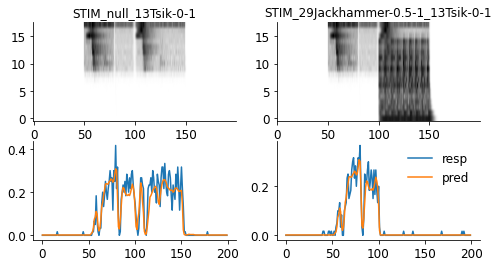

In [13]:
f,ax=plt.subplots(2,2, figsize=(8,4))

epoch="STIM_null_13Tsik-0-1"
s=ctx['val']['stim'].extract_epoch(epoch)
r=ctx['val']['resp'].extract_epoch(epoch)
p=ctx['val']['pred'].extract_epoch(epoch)

ax[0,0].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[0,0].set_title(epoch)
ax[1,0].plot(r[0,0,:],label='resp')
ax[1,0].plot(p[0,0,:],label='pred')

epoch="STIM_29Jackhammer-0.5-1_13Tsik-0-1"
s=ctx['est']['stim'].extract_epoch(epoch)
r=ctx['est']['resp'].extract_epoch(epoch)
p=ctx['est']['pred'].extract_epoch(epoch)

ax[0,1].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[0,1].set_title(epoch)
ax[1,1].plot(r[0,0,:],label='resp')
ax[1,1].plot(p[0,0,:],label='pred')
ax[1,1].legend(frameon=False)

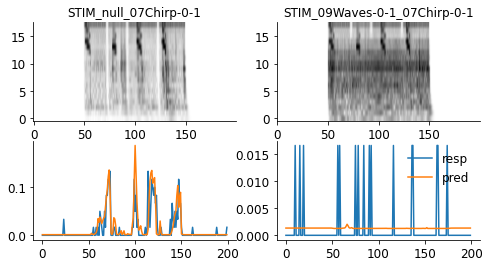

In [16]:
f,ax=plt.subplots(2,2, figsize=(8,4))

epoch="STIM_null_07Chirp-0-1"
s=ctx['val']['stim'].extract_epoch(epoch)
r=ctx['val']['resp'].extract_epoch(epoch)
p=ctx['val']['pred'].extract_epoch(epoch)

ax[0,0].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[0,0].set_title(epoch)
ax[1,0].plot(r[0,0,:],label='resp')
ax[1,0].plot(p[0,0,:],label='pred')

epoch="STIM_09Waves-0-1_07Chirp-0-1"
s=ctx['est']['stim'].extract_epoch(epoch)
r=ctx['est']['resp'].extract_epoch(epoch)
p=ctx['est']['pred'].extract_epoch(epoch)

ax[0,1].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[0,1].set_title(epoch)
ax[1,1].plot(r[0,0,:],label='resp')
ax[1,1].plot(p[0,0,:],label='pred')
ax[1,1].legend(frameon=False)

In [12]:
ax[0].imshow(s[0,:,:],aspect='auto',origin='lower',cmap='gray_r')
ax[1].plot(r[0,0,:],label='resp')
ax[1].plot(p[0,0,:],label='pred')

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'